# Бизнес анализ статистики результатов за полгода продаж интернет-приложения Procrastinate Pro+

## Цель проекта: 
разобраться в причинах убытков последних месяцев и дать рекомендации, как выйти в плюс.

## Задачи проекта:
изучить:
1. откуда приходят пользователи и какими устройствами они пользуются ?
2. сколько стоит привлечение пользователей из различных рекламных каналов ?
3. сколько денег приносит каждый клиент ?
4. когда расходы на привлечение клиента окупаются ?
5. какие факторы мешают эффективности привлечения клиентов ?

## Исходные данные:
Исходные данные охватывают **группу пользователей, привлеченных с 1 мая по 27 октября 2019 года**, и включают:
* `visits_info_short.csv —` хранит лог сервера с информацией о посещениях сайта данной группой пользователей,
* `orders_info_short.csv —` информацию о покупках, совершенных данной группой пользователей,
* `costs_info_short.csv  —` информацию о расходах на рекламу в период привлечения данной группы пользователей.

Структура **visits_info_short.csv**:
* `user_id       —` уникальный идентификатор пользователя,
* `region        —` страна пользователя,
* `device        —` тип устройства пользователя,
* `channel       —` идентификатор источника перехода,
* `session_start —` дата и время начала сессии,
* `session_end   —` дата и время окончания сессии.

Структура **orders_info_short.csv**
* `user_id       —` уникальный идентификатор пользователя,
* `order_dt      —` дата и время покупки, (**NB!**: в оригинале `event_dt`)
* `revenue       —` сумма заказа.

Структура **costs_info_short.csv**
* `channel       —` идентификатор рекламного источника,
* `pub_dt        —` дата проведения рекламной кампании, (**NB!**: в оригинале `dt`)
* `costs         —` расходы на эту кампанию.

\*) *названия колонок даны в соответствии с предобработанными датасетами ниже (согласно соглашениям о нотации в Python)*

Также дано: 
* **дата проведения анализа 1 ноября 2019 года**;
* бизнес-плане заложено, что **пользователи должны окупаться не позднее чем через две недели после привлечения**. 
(то есть на 15-й день, включая день привлечения - или на день номер 14 при нумерации дней с нуля)

In [1]:
# здесь соберем все импортируемые библиотеки и функции
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

# Подготовка исходных данных к анализу

Считываем исходные файлы в переменные типа датафрейм:

In [2]:
# предполагая исполнение на разных платфрмах, используем try-except для избежания ошибок на стороне исполнителя или ревьювера
try:
    sessions_df = pd.read_csv('datasets/visits_info_short.csv')
    orders_df = pd.read_csv('datasets/orders_info_short.csv')
    pubcosts_df = pd.read_csv('datasets/costs_info_short.csv')
except:
    sessions_df = pd.read_csv('/datasets/visits_info_short.csv')
    orders_df = pd.read_csv('/datasets/orders_info_short.csv')
    pubcosts_df = pd.read_csv('/datasets/costs_info_short.csv')

## Ознакомление с исходными данными и проверка нотации, типов и дупликатов  

### Журнал пользовательских сессий

In [3]:
sessions_df.head()

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

In [4]:
sessions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Пустых значений и пропусков данных нет

Исправляем **нотацию**:

In [5]:
sessions_df.rename(str.lower, axis='columns', inplace=True)
def put_underscore(s): return s.replace(' ', '_')
sessions_df.rename(put_underscore, axis='columns', inplace=True)

Приводим **типы данных**:

In [6]:
sessions_df['session_start'] = pd.to_datetime(sessions_df['session_start'])
sessions_df['session_end'] = pd.to_datetime(sessions_df['session_end'])

Проверяем **полные дупликаты**:

In [7]:
print('Кол-во дупликатов:',sessions_df.drop(columns='session_end').duplicated().sum()) # конец сессии не всегда известен

Кол-во дупликатов: 0


### Журнал заказов

In [8]:
orders_df.head()

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

In [9]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Пустых значений и пропусков данных нет

Исправляем **нотацию**:

In [10]:
orders_df.rename(str.lower, axis='columns', inplace=True)
# def put_underscore(s): return s.replace(' ', '_') # уже определена выше
orders_df.rename(put_underscore, axis='columns', inplace=True)
orders_df.rename(columns={'event_dt':'order_dt'}, inplace=True) # event не достаточно специфицирует dt, так что заменим на order

Приводим **типы данных**:

In [11]:
orders_df['order_dt'] = pd.to_datetime(orders_df['order_dt'])

Проверяем **полные дупликаты**:

In [12]:
print('Кол-во дупликатов:',orders_df.duplicated().sum())

Кол-во дупликатов: 0


### Журнал оплаты рекламы

In [13]:
pubcosts_df.head()

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

In [14]:
pubcosts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Пустых значений и пропусков данных нет.

Согласно нашим представлениям, мы ожидем увидеть в этом файле ежедневную оплату маркетинговым партнерам за рекламу - проверим, соответствует ли это записям датасета:

In [15]:
print('количество дней между 2019-05-01 и 2019-10-27 включительно равно', 
      (datetime(2019,10,27)-datetime(2019,5,1))//timedelta(days=1)+1 )

количество дней между 2019-05-01 и 2019-10-27 включительно равно 180


In [16]:
pubcosts_df['Channel'].value_counts().sort_index()

AdNonSense            180
FaceBoom              180
LeapBob               180
MediaTornado          180
OppleCreativeMedia    180
RocketSuperAds        180
TipTop                180
WahooNetBanner        180
YRabbit               180
lambdaMediaAds        180
Name: Channel, dtype: int64

Да, мы видим 10 партнеров по размещению платной рекламы, для каждого есть 180 записей об оплате - по числу дней в целевом периоде.  Все соответствует ожиданиям.

Исправляем **нотацию**:

In [17]:
pubcosts_df.rename(str.lower, axis='columns', inplace=True)
# def put_underscore(s): return s.replace(' ', '_') # уже определена выше
pubcosts_df.rename(put_underscore, axis='columns', inplace=True)
pubcosts_df.rename(columns={'dt':'pub_dt'}, inplace=True) # у нас эти dt повсюду, так что добавим спецификатор pub (реклама)

Приводим **типы данных**:

In [18]:
pubcosts_df['pub_dt'] = pd.to_datetime(pubcosts_df['pub_dt'])

Проверяем **полные дупликаты**:

In [19]:
print('Кол-во дупликатов:',pubcosts_df.duplicated().sum())

Кол-во дупликатов: 0


## Проверка связности данных и их соответствия ожидаемым ограничениям 

### Требование: временнЫе маркеры соответствуют целевой группе исследуемых пользователей

Целевая группа определена как пользователи, привлеченные в период с 2019-05-01 по 2019-10-27 включительно.  При этом у нас нет журнала регистраций, а также информация о сессиях не содержит параметра, который позволил бы точно утверждать, что данный пользователь впервые зарегистрировался во время данной сессии, привлеченный рекламой от даты начала сессии. 

Возможны два варианта, как выбирались исходные данные:
1. взяты тупо все данные с даты 2019-05-01 по дату 2019-10-27 + N дней до даты формирования данных (отрезаны как ножницами - простым фильтром) ,
2. после шага 1 проведена дополнительная проверка по журналу регистраций и убраны данные пользователей, привлеченных до 2019-05-01 или после 2019-10-27 

В первом варианте у нас на протяжении 2-3 периодов T удержания пользователя будут завышены размеры когорт и ROI (так как мы примем действия пользователей, зарегистрированных еще в апреле, за действия пользователей первых майских когорт, а расходы на рекламу будут считаться по дням после 2019-05-01).  Но благодаря экспоненциальному характеру удержания $e^{-t/T}$, этот эффект полностью затухнет после 2-3 периодов T удержания пользователя.

Также и к концу целевого периода возможны противоположные эффекты - то есть помимо того, что (естественно) мы не увидим полностью LTV от последних когорт, но получим полный CAC по последним когортам, соответственно их ROI будет занижен, - помимо этого у нас в датасетах могут оказаться данные по пользователям, привлеченным после 2019-10-27.  Но этих мы можем отловить, и исключить из датасетов их данные (к сожалению, мы не можем сделать зеркальное удаление нецелевых пользователей из первых когорт!).

Оба концевых эффекта приводят к тому, что горизонт достоверного анализа рекомендуется устанавливать с обоих концов целевого периода в 3 периода удержания пользователя от первой и последней даты в данных. 

Посмотрим, какие временнЫе данные присутствуют в датасетах:

In [20]:
time_statistics = sessions_df[['session_start','session_end']].describe(datetime_is_numeric=True)
time_statistics['order_dt'] = orders_df['order_dt'].describe(datetime_is_numeric=True)
time_statistics['pub_dt'] = pubcosts_df['pub_dt'].describe(datetime_is_numeric=True)

display(time_statistics.drop(['mean','25%','50%','75%']))

session_start          session_end             order_dt  \
count               309901               309901                40212   
min    2019-05-01 00:00:41  2019-05-01 00:07:06  2019-05-01 00:28:11   
max    2019-10-31 23:59:23  2019-11-01 01:38:46  2019-10-31 23:56:56   

                    pub_dt  
count                 1800  
min    2019-05-01 00:00:00  
max    2019-10-27 00:00:00

Проанализируем статистику временных данных выше - пойдем справа налево:
* даты отплаченной рекламы полностью соответствуют целевой группе;
* даты заказов также не противоречат целевой группе;
* для дат окончания сессий достаточно условия, что session_end > session_start;
* даты начала сессий также возможны, если только для любого user_id, стартовавшего сессию после 2019-10-27, найдется сессия с тем же user_id ранее 2019-10-27 включительно.
Проверим последние два условия:

In [21]:
(sessions_df['session_start'] < sessions_df['session_end']).count() # если совпадает с размером датафрейма, то ОК !

309901

In [22]:
last_daytime = datetime(2019,10,27,23,59,59)
after_last_day = sessions_df.query('session_start > @last_daytime')
before_last_day = sessions_df.query('session_start <= @last_daytime')

check_if_in_target = after_last_day[['user_id','session_start']].merge(before_last_day[['user_id','session_start']], 
                                                  how='left', on='user_id', suffixes=('_after', '_before'))
print('Зарегистрировалось после 2019-10-27 всего', check_if_in_target['session_start_before'].isna().sum(), 'пользователей')

Зарегистрировалось после 2019-10-27 всего 0 пользователей


**Все в порядке: предположение варианта 1, что исходные данные отрезали ножницами простого фильтра по временным ограничениям, не подтвердилось!**

### Требование: для каждого заказа должна быть сессия с одинаковым user_id 
(времена могут не совпадать - так как завершение согласования интернет заказов часто происходит по телефону при отзвонах)

In [23]:
check_if_registered = orders_df.merge(sessions_df[['user_id','session_start']], how='left', on='user_id')

orders_vs_regs = check_if_registered.sort_values('session_start').groupby(by=['user_id','order_dt'],as_index=False).agg('first')
orders_vs_regs.rename(columns={'session_start':'registration_dt'},inplace=True)

print('заказов без регистрации', orders_vs_regs['registration_dt'].isna().sum() )

заказов без регистрации 0


### Требование: для каждого заказа регистрация пользователя должна предшествовать заказу 
(иначе будут заказы, не относящиеся к когортам - это также дополнительная проверка правильности определения даты регистрации)

In [24]:
(orders_vs_regs['order_dt'] < orders_vs_regs['registration_dt']).sum() # если 0, то ОК !

0

### Требование: соотношение 1:1 или 1:многим для пользователя и его страны, устройства, канала привлечения
один и тот же пользователь может заходить в приложение с разных мобильных устройств, под влияним разных каналов привлечения и в общем случае из разных стран (находясь в роуминге).  Нужно проверить, чтобы избежать сложностей в коде:

In [25]:
check_one_to_many = sessions_df.drop(columns=['session_start','session_end']).groupby(by='user_id').agg('nunique')

print('Один пользователь может открывать сессии максимум из', check_one_to_many['region'].max(), 'разных стран')
print('Один пользователь может открывать сессии максимум c', check_one_to_many['device'].max(), 'разных устройств')
print('Один пользователь может переходить на сайт приложения максимум из', check_one_to_many['channel'].max(), 'разных каналов привлечения')

Один пользователь может открывать сессии максимум из 1 разных стран
Один пользователь может открывать сессии максимум c 4 разных устройств
Один пользователь может переходить на сайт приложения максимум из 5 разных каналов привлечения


Возможно, под страной пользователя (region) подразумевается страна проживания, а не страна роуминга.  Или желающих пользоваться приложением в роуминге нет.  В любом случае, **только для страны (region) соответствие пользователю (user_id) 1:1**.

### Итак, все требования к связности данных выполнены / проверены

## Исходные данные готовы к анализу:

In [26]:
print('----------------------------------------журнал сессий------------------------')
sessions_df.info()
print('-----------------------------------------------------------------------------')
print('----------------------------------------журнал заказов ----------------------')
orders_df.info()
print('-----------------------------------------------------------------------------')
print('----------------------------------------журнал оплаты рекламы----------------')
pubcosts_df.info()

----------------------------------------журнал сессий------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
-----------------------------------------------------------------------------
----------------------------------------журнал заказов ----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    -

# Исследовательский анализ данных (EDA)

## Профили пользователей и конверсия визитеров в покупателей

### Даты привлечения (регистрации)
Во время проверок связности данных мы уже определили даты привлечения (регистрации) пользователей как момент первой сессии данного пользователя в датасете sessions_df.  Такой подход содержит потенциальный риск включения всех пользователей, присоединившихся ранее 2019-05-01 в первые когорты, что - как уже было отмечено - исказит CAC первых когорт в сторону уменьшения, а ROI - соответственно, в сторону завышения.  Заодно наличие данного искажения подтвердит наше предположение, что мы не можем полностью избавиться в данных от пользователей, ошибочно рассматриваемых, как часть целевой группы.  Их влияние ожидается к затуханию только после 2-3 периодов удержания пользователей с начала целевого периода времени.

#### Создание датасета профилей пользователей users_df

In [27]:
users_df = sessions_df.sort_values('session_start').groupby(by='user_id',as_index=False).agg(
           {'session_start':'first','channel':'first','device':'first','region':'first'}).rename(
           columns={'session_start':'registration_dt','channel':'reg_channel','device':'reg_device','region':'country'})

In [28]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150008 entries, 0 to 150007
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   user_id          150008 non-null  int64         
 1   registration_dt  150008 non-null  datetime64[ns]
 2   reg_channel      150008 non-null  object        
 3   reg_device       150008 non-null  object        
 4   country          150008 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 6.9+ MB


In [29]:
users_df['registration_dt'].describe(datetime_is_numeric=True)

count                           150008
mean     2019-07-31 21:05:58.760119808
min                2019-05-01 00:00:41
25%      2019-06-16 08:15:39.249999872
50%         2019-08-03 12:07:04.500000
75%      2019-09-18 20:51:20.249999872
max                2019-10-27 23:59:04
Name: registration_dt, dtype: object

Как видно из статистики столбца регистраций, регистрации начинаются в первый час 2019-05-01 и продолжаются до последних секунд 2019-10-27.  

**Замечание**: пользователи находятся в разных часовых поясах, поэтому по локальному времени они могут регистрироваться и выходя на сутки за пределы диапазона дат, но нам важно, по какому времени оплачивается реклама, так как именно это определяет CAC по когортам.  Поэтому все правильно, что мы определяем время регистрации по единому времени, а не по локальному для пользователя.

#### Поэтому определяем минимальную и максимальную даты регистраций как:

In [30]:
min_reg_dt = datetime(2019,5,1)
max_reg_dt = datetime(2019,10,27)
print('Дата первой регистрации в целевой группе пользователей', min_reg_dt.year, '-', min_reg_dt.month, '-', min_reg_dt.day)
print('Дата последней регистрации в целевой группе пользователей', max_reg_dt.year, '-', max_reg_dt.month, '-', max_reg_dt.day)

Дата первой регистрации в целевой группе пользователей 2019 - 5 - 1
Дата последней регистрации в целевой группе пользователей 2019 - 10 - 27


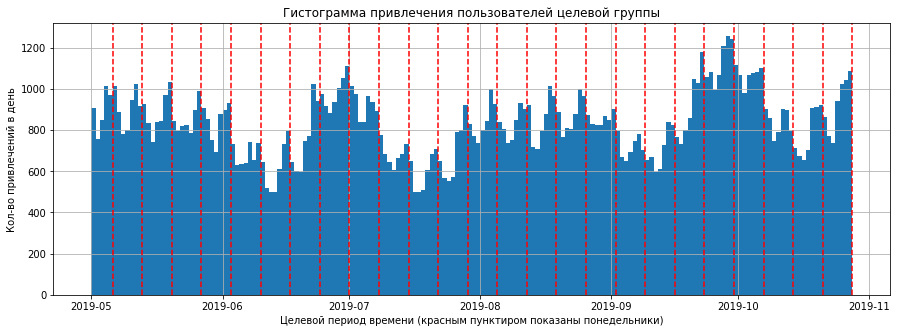

In [31]:
users_df['registration_dt'].hist( bins=(max_reg_dt-min_reg_dt).days+1, figsize=(15,5) )

plt.title('Гистограмма привлечения пользователей целевой группы')
plt.ylabel('Кол-во привлечений в день')
plt.xlabel('Целевой период времени (красным пунктиром показаны понедельники)')

for d in range((max_reg_dt-min_reg_dt).days+2):
    if (min_reg_dt + timedelta(days=d)).weekday() == 0:
        plt.axvline(x=(min_reg_dt + timedelta(days=d)), color='red', linestyle='--') # ставим отметки понедельников

plt.show()

мы видим на гистограмме в динамике привлечения пользователей: 
1. средний уровень регистраций порядка 800 привлеченных пользователей в день; 
2. частые недельные биения +/- 100 ежедневных регистраций, причем четко прослеживается закономерность, что в первой половине недели идет падение, а во второй - рост.  Максимум достигается на выходных, с переходом на понедельник.  Вероятнее всего, что заброс на понедельник вызван просто разницей часовых поясов, которая размазывает недельную динамику на +/- полсуток;
3. медленные волны с периодом порядка 6.5 недель, но большей амплитуды.  Причем, эти волны идут парами: одна волна пошире и меньшей амплитуды +/- 200 ежедневных регистраций, вторая более резкая +/- 300 ежедневных регистраций, но более короткая. В сумме продолжительность такой пары занимает квартал, который начинается с двухнедельного падения регистраций, затем резкий пик роста, потом идет следующее падение в середине квартала и завершается более покатым пиком роста.  Вероятно, это связяно с поквартальным процессом выделения маркетингового бюджета и подведения итогов маркетинговых кампаний;
4. можно так же заметить во второй половине целевого периода долгий тренд роста (+ 100 ежедневных регистраций за 9 недель), который является частью более медленной динамики с длиной волны превышающей целевой период, поэтому оценить его периодичность и амплитуду невозможно. Можно предположить, что это сезонные эффекты с периодичностью в один год.

#### Промежуточные выводы: 
привлечение пользователей имеет, предположительно, сезонную динамику, промодулированную квартальной динамикой с парой из резкого и пологого пиков ежедневных регистраций, предположительно маркетингового характера (глубина модуляции порядка 20%), и, в свою очередь, промодулированную недельной динамикой активности пользователей с ростом таковой в конце недели и падением в начале (глубина модуляции порядка 10%).

### Определение платящих пользователей

Пользователь является платящим, если он разместил хотя бы один заказ.  То есть, список платящих пользователей совпадает со списком уникальных значений user_id в датасете orders_df.  Добавим признак плательщика в users_df.

Добавление поля is_payer можно делать построчной функцией, но мы будем использовать левый merge с выбрасыванием дупликатов в конце- так работает гораздо быстрее, чем заполнение построчной функцией:

In [32]:
tmp_df = users_df.merge(orders_df[['user_id','order_dt']], how='left', on='user_id') # order_dt будет NaT, если нет заказа
# если заказы есть, то в tmp_df появятся строки , отличеющиеся только датой заказа, если его выбросить, то станут дупликатами

# отсюда идея, как добавить в users_df столбец 'is_payer':
tmp_df['is_payer'] = tmp_df['order_dt'].notna()
users_df = tmp_df.drop(columns='order_dt').drop_duplicates().reset_index(drop=True)

# сверим кол-во пользователей
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150008 entries, 0 to 150007
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   user_id          150008 non-null  int64         
 1   registration_dt  150008 non-null  datetime64[ns]
 2   reg_channel      150008 non-null  object        
 3   reg_device       150008 non-null  object        
 4   country          150008 non-null  object        
 5   is_payer         150008 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(1), object(3)
memory usage: 5.9+ MB


In [33]:
print('Всего платящих пользователей', users_df['is_payer'].sum() )
print('Доля платящих пользователей составляет', round(users_df['is_payer'].sum()/users_df['is_payer'].count()*100,2), '%')

Всего платящих пользователей 8881
Доля платящих пользователей составляет 5.92 %


Сразу посмотрим на статистику только по платящим пользователям:

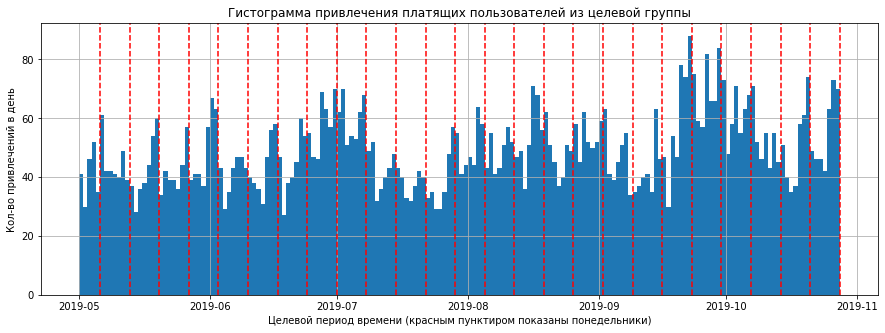

In [34]:
users_df.query('is_payer')['registration_dt'].hist( bins=(max_reg_dt-min_reg_dt).days+1, figsize=(15,5) )

plt.title('Гистограмма привлечения платящих пользователей из целевой группы')
plt.ylabel('Кол-во привлечений в день')
plt.xlabel('Целевой период времени (красным пунктиром показаны понедельники)')

for d in range((max_reg_dt-min_reg_dt).days+2):
    if (min_reg_dt + timedelta(days=d)).weekday() == 0:
        plt.axvline(x=(min_reg_dt + timedelta(days=d)), color='red', linestyle='--') # ставим отметки понедельников

plt.show()

#### Промежуточные выводы: 
с привлечением плятящих пользователей проблем не видно - характер истории привлечений платящих пользователей повторяет характер истории привлечений для всех пользователей.  Поэтому проблемы убытков бизнеса следует искать либо в падении LTV у последних когорт (исключая естественный эффект обрезания LTV последней датой датафрейма, которая составляет плюс 3 суток к max_reg_date), либо в росте CAC у последних когорт.

Единственная разница гистограммы платящих по сравнению со всеми - она более стохастична, что понятно, так как относительная стохастическая ошибка порядка $1/\sqrt{размер\ когорты}$, соответственно, если для всех пользователей это было $1/\sqrt{800}=3.5\%$, то для платящих пользователей она составила $1/\sqrt{40}=15.8\%$.

Кстати, заметим, что для вычисления средних по выборке, размер когорты еще достаточно репрезентативен, так как гистограмма везде выше уровня 30 ежедневных регистраций платящих абонентов!

### Страны пользователей

#### Обогащение датафрейма сессий пользователя информацией о наличии заказов
Как мы проверили при исследовании связности и непротиворечивости исходных данных, соответствие между user_id и region 1:1, поэтому для анализа по странам пользователей можно было бы использовать датафрейм users_df, добавив в него информацию по стране. Но поскольку далее нам придется анализировать также влияние других параментов сессии (устройства и канала привлечения, по которы мы обнаружили соответствие 1:много), то для единообразия подхода обогатим сразу датафрейм пользовательских сессий.


In [35]:
sessions_df = sessions_df.merge(users_df[['user_id','is_payer']], how='left', on='user_id')
# поскольку в датасете users_df все пользователи уникальны, то такой левый merge не увеличивает кол-во записей в session_df:
sessions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309901 entries, 0 to 309900
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
 6   is_payer       309901 non-null  bool          
dtypes: bool(1), datetime64[ns](2), int64(1), object(3)
memory usage: 16.8+ MB


Определим список стран (регионов) и упорядочим его в порядке убывания платных пользователей за весь период.  Для каждой страны найдем долю платящих среди всех пользователей. Бонусом определим доли разных стран в полном списке платных пользователей

In [36]:
payers_vs_regions = sessions_df[['user_id','region','is_payer']].drop_duplicates( # оставляем уникальные user_id
    ).groupby(by='region', as_index=False).agg({'user_id':'count','is_payer':'sum'}).rename(
    columns={'user_id':'nof_users','is_payer':'nof_payers'}).sort_values(
    by='nof_payers', ascending=False).reset_index(drop=True)

payers_vs_regions['payers_chare_%'] = round(payers_vs_regions['nof_payers'] / payers_vs_regions['nof_users'] * 100, 2)

total_payers = payers_vs_regions['nof_payers'].sum()
payers_vs_regions['ww_payers_share_%'] = round(payers_vs_regions['nof_payers'] / total_payers * 100, 2)

display(payers_vs_regions)
print('--------------------------------------------------------------')
print('Всего платящих пользователей', total_payers, 
      '(должно совпасть с прошлым значением платящих пользователей в датафрейме users_df выше)')

region  nof_users  nof_payers  payers_chare_%  ww_payers_share_%
0  United States     100002        6902            6.90              77.72
1             UK      17575         700            3.98               7.88
2         France      17450         663            3.80               7.47
3        Germany      14981         616            4.11               6.94

--------------------------------------------------------------
Всего платящих пользователей 8881 (должно совпасть с прошлым значением платящих пользователей в датафрейме users_df выше)


**Заметим**, что хотя по абсолютным величинам Германия находится в конце списка, однако по доли платящих пользователей она опережает и Англию и Францию.

### Устройства пользователей (типы)
Определим список устройств, с которых пользователи заходят в приложение, и упорядочим его в порядке убывания платных пользователей за весь период.  Для каждого типа устройства найдем долю платящих среди всех пользователей.

А вот с бонусным определением доли разных устройств в полном списке платных пользователей так уже не получится - так как часть пользователей пользуется несколькими устройствами, и если мы аддитивно сложим пользователей по устройствам, без учета пересечений, то получим больше пользователей, чем есть в реальности.

In [37]:
payers_vs_devices = sessions_df[['user_id','device','is_payer']].drop_duplicates( # оставляем уникальные пары (user_id, device)
    ).groupby(by='device', as_index=False).agg({'user_id':'count','is_payer':'sum'}).rename(# в группе device уникальные user_id
    columns={'user_id':'nof_users','is_payer':'nof_payers'}).sort_values(
    by='nof_payers', ascending=False).reset_index(drop=True)

payers_vs_devices['payers_share_%'] = round(payers_vs_devices['nof_payers'] / payers_vs_devices['nof_users'] * 100, 2)

total_payers = payers_vs_devices['nof_payers'].sum()

display(payers_vs_devices)
print('--------------------------------------------------------------')
print('Видим, что прямая сумма по столбцу nof_payers', total_payers, '(больше чем кол-во платящих пользователей!)')


device  nof_users  nof_payers  payers_share_%
0   iPhone      55798        3768            6.75
1  Android      36377        2458            6.76
2      Mac      31335        2346            7.49
3       PC      31681        1947            6.15

--------------------------------------------------------------
Видим, что прямая сумма по столбцу nof_payers 10519 (больше чем кол-во платящих пользователей!)


**Заметим**, что хотя по мобильным платформам Apple имеет близкую долю платящих пользователей, что и вендор-независимая платформа, однако на стационарных платформах он существенно опережает PC.

### Каналы привлечения пользователей
Определим список маркетинговых каналов, по которым пользователи переходят в приложение, и упорядочим его в порядке убывания платных пользователей за весь период.  Для каждого канала найдем долю платящих среди всех пользователей.

Аналогично: с бонусным определением доли разных каналов в полном списке платных пользователей так просто (как в случае стран) уже не получится - так как часть пользователей попадает по разным каналам в разные сессии, и если мы аддитивно сложим пользователей по каналам, без учета пересечений, то получим больше пользователей, чем есть в реальности.  Это кажется странным - естественно полагать, что пользователи распределены по каналам и в сумме должны дать 100% - так и будет, если вместо сессионных каналов использовать только канал регистрации - единственный для пользователя.

In [38]:
payers_vs_channels = sessions_df[['user_id','channel','is_payer']].drop_duplicates(# оставляем уникальные пары (user_id,channel)
    ).groupby(by='channel', as_index=False).agg({'user_id':'nunique','is_payer':'sum'}).rename(# в группе channel уникальные user_id
    columns={'user_id':'nof_users','is_payer':'nof_payers'}).sort_values(
    by='nof_payers', ascending=False).reset_index(drop=True)

payers_vs_channels['payers_share_%'] = round(payers_vs_channels['nof_payers'] / payers_vs_channels['nof_users'] * 100, 2)

total_payers = payers_vs_channels['nof_payers'].sum()

display(payers_vs_channels)
print('--------------------------------------------------------------')
print('Видим, что прямая сумма по столбцу nof_payers', total_payers, '(больше чем кол-во платящих пользователей!)')


channel  nof_users  nof_payers  payers_share_%
0             FaceBoom      29916        3832           12.81
1               TipTop      20204        2054           10.17
2              organic      57673        1436            2.49
3       RocketSuperAds       4988         558           11.19
4           AdNonSense       4199         556           13.24
5       WahooNetBanner       8845         538            6.08
6         MediaTornado       4895         392            8.01
7              YRabbit       4882         380            7.78
8              LeapBob       8875         365            4.11
9   OppleCreativeMedia       8929         336            3.76
10      lambdaMediaAds       2410         323           13.40

--------------------------------------------------------------
Видим, что прямая сумма по столбцу nof_payers 10770 (больше чем кол-во платящих пользователей!)


Здесь у нас совсем мало корреляции между абсолютными величинами и долями платящих - канал с максимальной долей платящих оказался в самом конце при упорядочивании по абсолютным кол-вам покупателей!

#### Промежуточные выводы: 
после изучения зависимостей долей плятящих пользователей от дополнительных параметров (страна, устройство и канал привлечения) мы можем дополнить рекомендации предыдущих предварительных выводов предположением, что причины убыточности бизнеса следует скорее искать детальным исследованием CAC последних когорт, нежели поиском падений LTV в последних когортах. 

## Затраты на маркетинг - интегральная метрика CAC

**Дисклаймер(ы) о денежных единицах**: мне не удалось найти в описании проекта упоминание, в каких денежных единицах измеряется revenue и costs в исходных данных.  Список стран пользователя позволяет предположить, что это либо доллары, либо евро, также не известно осуществлается ли счет единицами, тысячами или миллионами таковых.  Поэтому весь анализ денежных параметров происходит в УЕ (или "у.е." как в 90-е!) при следующих не проверяемых далее предположениях:
1. И ревеню, и косты измеряются в одних и тех же единицах;
2. Разные маркетинговые каналы учтены в костах в единых денежных единицах;
3. Вопросы (динамики) курсов денежных единиц и их корректного учета при приведении к единым денежным единицам не рассматриваются в данном исследовании.

При дальнейшей визуализации, чтобы не загромождать графики и таблицы длинными именами маркетинговых партнеров введем словарь их аббревиатур: 

In [39]:
ch_abbr = {
    'AdNonSense' : 'ANS',
    'FaceBoom' : 'FB',
    'LeapBob' : 'LB',
    'MediaTornado' : 'MT',
    'OppleCreativeMedia' : 'OCM',
    'RocketSuperAds' : 'RSA',
    'TipTop' : 'TT',
    'WahooNetBanner' : 'WNB',
    'YRabbit' : 'YR',
    'lambdaMediaAds' : 'LMA',
    'organic' : 'organic'
}

### Детальное изучение данных по затратам на маркетинг в датасете pubcosts_df
Из предобработки и EDA выше мы знаем, что используется 10 платных каналов (плюс 11-й безрекламный канал organic), период проведения оплат 180 дней, значит ожидается оплата 180\*10=1800 рекламо-дней.  Это соответствует кол-ву записей в датасете pubcosts_df.  Посмотрим детальную статистику - выведем ее по разным каналам отдельно:

In [40]:
daily_costs_per_channel_pvt = pubcosts_df.pivot_table(index='pub_dt', columns='channel',values='costs',aggfunc='sum')
daily_costs_per_channel_pvt.rename(columns=ch_abbr) # подменяем на аббревиатуры только в визуализации - датасеты не меняем!

channel       ANS     FB     LB     MT    OCM     RSA     TT   WNB     YR  \
pub_dt                                                                      
2019-05-01  40.95  113.3   2.52   6.24   4.25  21.060   80.0  10.8   8.10   
2019-05-02  34.65   78.1   2.94   5.04   4.25  16.965   55.0   7.2   9.90   
2019-05-03  47.25   85.8   2.73   6.96   5.75  16.380   64.0   8.4   9.00   
2019-05-04  51.45  136.4   3.99   9.36   4.25  17.550   70.0  10.8  15.60   
2019-05-05  36.75  122.1   4.62  11.04   5.50  27.495   78.0  12.0   9.60   
...           ...    ...    ...    ...    ...     ...    ...   ...    ...   
2019-10-23  15.75  178.2  10.71   5.28  13.25   5.525  322.0  31.8   6.48   
2019-10-24  21.00  222.2  12.81   5.04  12.50   5.850  402.5  42.0   7.29   
2019-10-25  26.25  255.2  14.70   6.24  16.50   7.150  483.0  37.2   7.56   
2019-10-26  21.00  272.8  14.28   6.72  14.25   4.550  563.5  40.8   5.67   
2019-10-27  35.70  233.2  12.81   4.56  17.75  10.075  588.0  42.0  11.07   

channel      LMA  
pub_dt            
2019-05-01  17.6  
2019-05-02  16.8  
2019-05-03  16.8  
2019-05-04  17.6  
2019-05-05  12.8  
...          ...  
2019-10-23   4.0  
2019-10-24   6.4  
2019-10-25   8.8  
2019-10-26   8.8  
2019-10-27  12.0  

[180 rows x 10 columns]

### Затраты на маркетинг по каналам и в целом
Просуммируем затраты по всем 180 дням по каждому каналу и в целом, также рассчитаем удельную долю каждого канала:

In [41]:
marketing_totals_pvt = daily_costs_per_channel_pvt.copy(deep=True)
marketing_totals_pvt['ALL_CH'] = marketing_totals_pvt.T.sum()

marketing_totals_pvt_TR = marketing_totals_pvt.T # строки с суммами удобно добавлять в транспонированном виде
marketing_totals_pvt_TR['all_cohorts'] = marketing_totals_pvt.sum()
marketing_totals_pvt_TR['share_among_channels_%'] = round(100 *
                                                           marketing_totals_pvt_TR['all_cohorts'] / 
                                                           marketing_totals_pvt_TR.loc['ALL_CH','all_cohorts'],2
                                                           )
marketing_totals_pvt_TR.T.rename(columns=ch_abbr)

channel                     ANS        FB       LB      MT      OCM       RSA  \
pub_dt                                                                          
2019-05-01 00:00:00       40.95    113.30     2.52    6.24     4.25    21.060   
2019-05-02 00:00:00       34.65     78.10     2.94    5.04     4.25    16.965   
2019-05-03 00:00:00       47.25     85.80     2.73    6.96     5.75    16.380   
2019-05-04 00:00:00       51.45    136.40     3.99    9.36     4.25    17.550   
2019-05-05 00:00:00       36.75    122.10     4.62   11.04     5.50    27.495   
...                         ...       ...      ...     ...      ...       ...   
2019-10-25 00:00:00       26.25    255.20    14.70    6.24    16.50     7.150   
2019-10-26 00:00:00       21.00    272.80    14.28    6.72    14.25     4.550   
2019-10-27 00:00:00       35.70    233.20    12.81    4.56    17.75    10.075   
all_cohorts             3911.25  32445.60  1797.60  954.48  2151.25  1833.000   
share_among_channels_%     3.71     30.75     1.70    0.90     2.04     1.740   

channel                      TT      WNB      YR      LMA      ALL_CH  
pub_dt                                                                 
2019-05-01 00:00:00        80.0    10.80    8.10    17.60     304.820  
2019-05-02 00:00:00        55.0     7.20    9.90    16.80     230.845  
2019-05-03 00:00:00        64.0     8.40    9.00    16.80     263.070  
2019-05-04 00:00:00        70.0    10.80   15.60    17.60     337.000  
2019-05-05 00:00:00        78.0    12.00    9.60    12.80     319.905  
...                         ...      ...     ...      ...         ...  
2019-10-25 00:00:00       483.0    37.20    7.56     8.80     862.600  
2019-10-26 00:00:00       563.5    40.80    5.67     8.80     952.370  
2019-10-27 00:00:00       588.0    42.00   11.07    12.00     967.165  
all_cohorts             54751.3  5151.00  944.22  1557.60  105497.300  
share_among_channels_%     51.9     4.88    0.90     1.48     100.000  

[182 rows x 11 columns]

Мы видим выполнение правила 80-на-20: 20% маркетинговых каналов (FaceBoom и TipTop - из десяти) у нас съедают 82,65% всего маркетингового бюджета на рекламу!  В реальной жизни, даже не смотря на дисклеймеры про денежные единицы, я бы позвонил автору данных по затратам на маркетинг - уточнить, не оказалось, ли, что эти двое учтены в рублях, а не в у.е.!  Деление на курс порядка 50 вернуло бы обоих в общий пул.  Но сейчас предположим, что мы уже это сделали и получили подтверждение, что исходные данные верны.  **Первая зацепка!**  Но, быть может, эти двое и платящих пользователей привлекают на все 80% ?!  Выводы делать рано.

Пока сделаем визуализацию подневной динамики костов на весь маркетинг и в каждом канале:

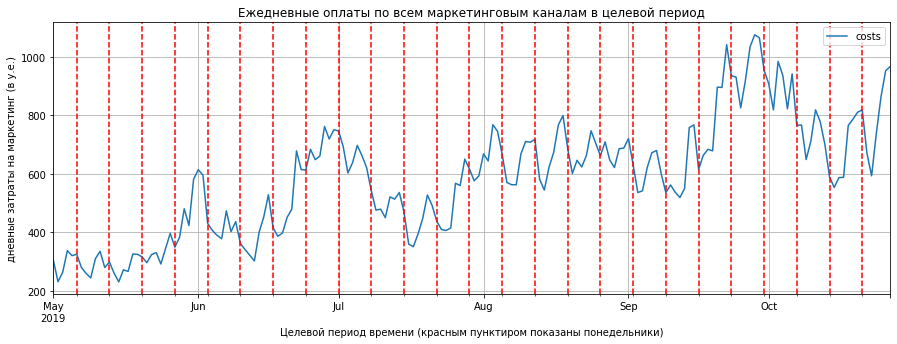

In [42]:
pubcosts_df.groupby(by='pub_dt', as_index=False).agg({'costs':'sum'}).sort_values('pub_dt').plot(
    x='pub_dt', y='costs', kind='line', grid=True, figsize=(15,5) )

plt.title('Ежедневные оплаты по всем маркетинговым каналам в целевой период')
plt.ylabel('дневные затраты на маркетинг (в у.е.)')
plt.xlabel('Целевой период времени (красным пунктиром показаны понедельники)')

for d in range((max_reg_dt-min_reg_dt).days+2):
    if (min_reg_dt + timedelta(days=d)).weekday() == 0:
        plt.axvline(x=(min_reg_dt + timedelta(days=d)), color='red', linestyle='--') # ставим отметки понедельников

plt.show()

Недельные и квартальные модуляции походят на поведение ежедневно привлекаемых абонентов, а вот длинноволновый тренд радикально иной - если кол-во привлекаемых пользователей медленного росло примерно на 10% в квартал, то расходы на маркетинг, как мы видим, выросли за это время почти в 2 раза - что, видимо, и привело к ситуации убытков в конце целевого периода: затраты на маркетинг превысили доход.

#### Сглаживание недельных пульсаций и определение роста среднеквартального тренда
У нас есть веские основания предполагать, что перид высокочастотной модуляции равен ровно одной неделе, поэтому если взять скользящее окно в 7 дней, по которому усреднять то квартальная динамика будет лучше видна.

Вероятно, таким же способом можно быстро увидеть и длинноволновой тренд, предположив, что квартальная динамика определяется процессов ежеквартального выделения маркетингового бюджета, под который подстраиваются маркетинговые кампании.

Проверим:

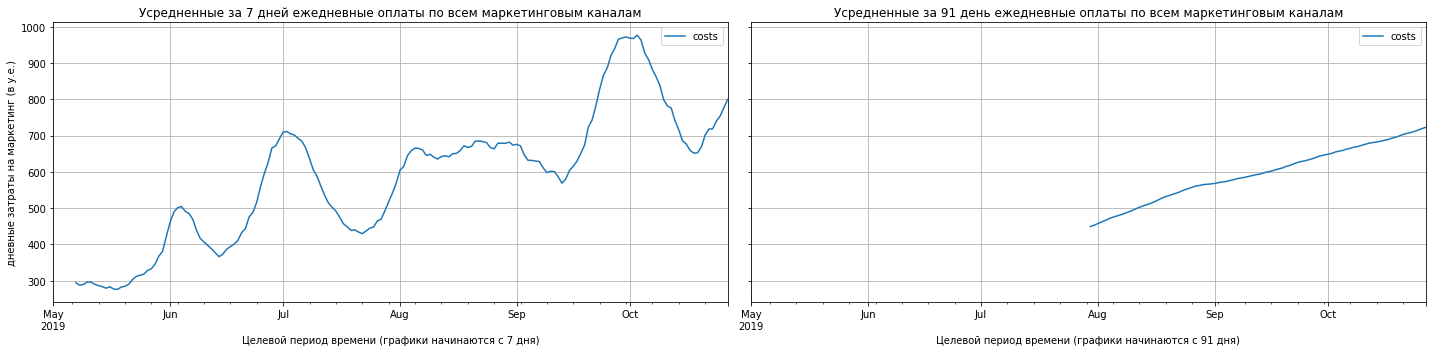

In [43]:
plt.figure(figsize=(20, 5))

ax1 = plt.subplot(1,2,1)
pubcosts_df.groupby(by='pub_dt').agg({'costs':'sum'}).rolling(7).mean().plot(
    kind='line', grid=True, ax=ax1 )

plt.title('Усредненные за 7 дней ежедневные оплаты по всем маркетинговым каналам')
plt.ylabel('дневные затраты на маркетинг (в у.е.)')
plt.xlabel('Целевой период времени (графики начинаются с 7 дня)')

ax2 = plt.subplot(1,2,2,sharey=ax1 )
pubcosts_df.groupby(by='pub_dt').agg({'costs':'sum'}).rolling(91).mean().plot(
    kind='line', grid=True, ax=ax2 )

plt.title('Усредненные за 91 день ежедневные оплаты по всем маркетинговым каналам')
plt.ylabel('дневные затраты на маркетинг (в у.е.)')
plt.xlabel('Целевой период времени (графики начинаются с 91 дня)')

plt.tight_layout()
plt.show()

Данный график позволяет довольно точно определить даже визуально скорость роста затрат на маркетинг между кварталами Q2 и Q3: $(730-450)/450 = 62\%$ за один квартал.  

#### Предварительные выводы:
маркетинговые расходы по всем каналам растут в среднем на 62% за один квартал в целевом периоде.  На данный долгий тренд накладывается квартальная модуляция из двух пиков в квартал - первый более резкий, второй более пологий, что, предположительно, определяется характером внутренного процесса поквартального выделения маркетингового бюджета, а также накладывается недельная модуляция, определяемая недельным циклом пользовательской активности, растущей к концу недели и достигающей пика на выходных. 

#### Сравнение долгосрочной динамики между разными каналами
Как мы убедились выше, самым содержательным для вопроса определения тренда затрат на маркетинг был график с поквартальным усреднением.  Поэтому для сравнения динамик между разными каналами используем именно его: 

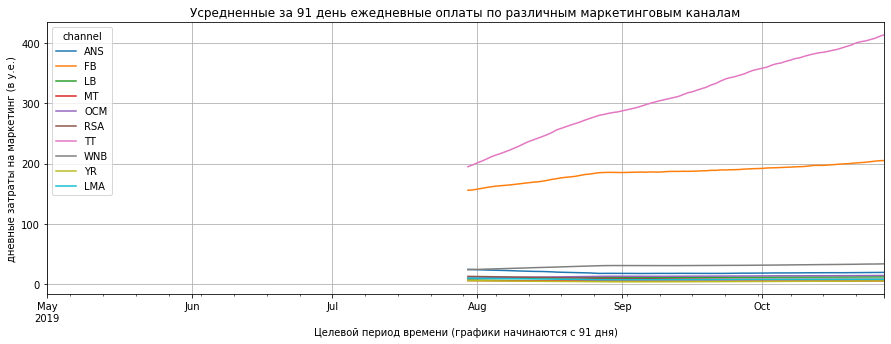

In [44]:
daily_costs_per_channel_pvt.rename(columns=ch_abbr).rolling(91).mean().plot(
    kind='line', grid=True, figsize=(15,5) )

plt.title('Усредненные за 91 день ежедневные оплаты по различным маркетинговым каналам')
plt.ylabel('дневные затраты на маркетинг (в у.е.)')
plt.xlabel('Целевой период времени (графики начинаются с 91 дня)')

plt.show()

Мы видим обоих "фаворитов" (TipTop и FaceBoom), из них наибольшие подозрения вызывает удвоение за квартал стоимости маркетинговых услуг от TipTop!  Остальные 8 каналов плохо видны на этом графике, из-за масштаба, задаваемого лидерами, поэтому посмотрим на них без лидеров:

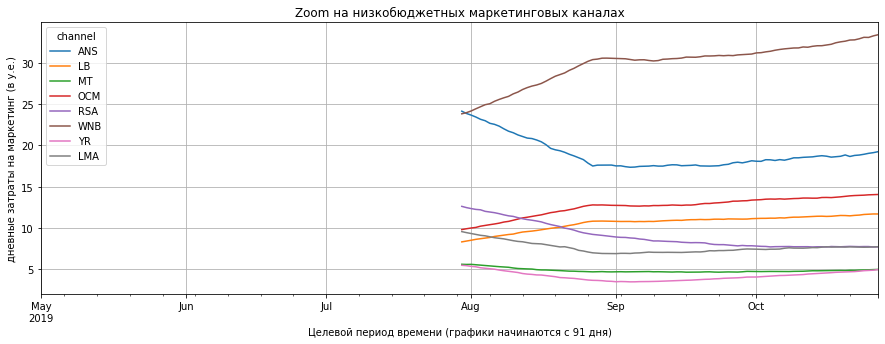

In [45]:
daily_costs_per_channel_pvt.rename(columns=ch_abbr).drop(columns=['TT','FB']).rolling(91).mean().plot(
    kind='line', grid=True, figsize=(15,5) )

plt.title('Zoom на низкобюджетных маркетинговых каналах')
plt.ylabel('дневные затраты на маркетинг (в у.е.)')
plt.xlabel('Целевой период времени (графики начинаются с 91 дня)')

plt.show()

Часть этих каналов также демонстрирует существенный рост - порядка 50% за квартал, но на фоне лидеров их вклад мал.  К тому же, одна часть растет - другая падает, трудно оценить в целом изменение их вклада.  Поэтому для наглядного сравнения влияния низкобюджетных каналов просуммуруем их вклад:

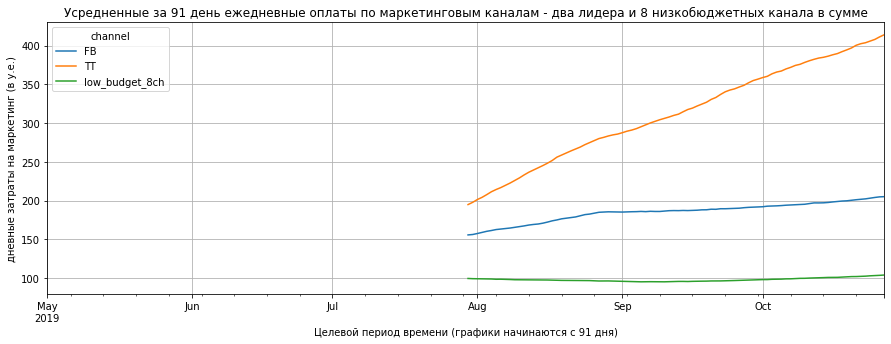

In [46]:
daily_costs_per_3ch_dup = daily_costs_per_channel_pvt.copy(deep=True) # чтобы не менять daily_costs_per_channel_pvt

low_budget_list = list(ch_abbr.keys())
low_budget_list.remove('FaceBoom')
low_budget_list.remove('TipTop')
low_budget_list.remove('organic')

daily_costs_per_3ch_dup['low_budget_8ch'] = daily_costs_per_3ch_dup[low_budget_list[0]] #нулем инициировать не можем -не тот тип
for ch in low_budget_list[1:]:
    daily_costs_per_3ch_dup['low_budget_8ch'] = daily_costs_per_3ch_dup['low_budget_8ch'] + daily_costs_per_3ch_dup[ch]
daily_costs_per_3ch_dup = daily_costs_per_3ch_dup.drop(columns=low_budget_list)

daily_costs_per_3ch_dup.rename(columns=ch_abbr).rolling(91).mean().plot(
    kind='line', grid=True, figsize=(15,5) )

plt.title('Усредненные за 91 день ежедневные оплаты по маркетинговым каналам - два лидера и 8 низкобюджетных канала в сумме')
plt.ylabel('дневные затраты на маркетинг (в у.е.)')
plt.xlabel('Целевой период времени (графики начинаются с 91 дня)')

plt.show()


Теперь все визуально очевидно для выводов!

#### Промежуточные выводы:
раздувание маркетингового бюджета в долгосрочной перспективе (то есть при усреднении модуляции от недельных - вызванных периодичностью активности пользователей - и квартальных - вызванных, предположительно, периодичностью выделения маркетингового бюджета - динамик) происходит из-за двух каналов, чья доля доросла до 90% в конце целевого периода:
1. лидером роста стал канал TipTop, который удваивает свой бюджет каждый квартал;
2. на втором месте FaceBoom, бюджет которого добавляет порядка одной трети в квартал.

остальные 8 каналов маркетинга в сумме остаются на одном уровне 100 у.е. в день на всех, но их относительная доля падает из-за роста лидеров. 

### Детальное изучение затрат на одного пользователя - метрика CAC
**Дисклаймер о модели оплаты за маркетинг**: сразу оговоримся, что у нас есть файл с подневными оплатами в маркетинговые каналы, но нам не известна модель тарификации в разных каналах.  Дальнейший когортный анализ будет предполагать, что оплата производится только за регистрации новых абонентов.  Если же по факту она привязана к переходам на сайт, или к размещению заказов, то у нас не просто будет неверно распределен CAC по каждому каналу во времени (что было бы не так проблемно при усреднении модуляций) - у нас часть тарифицируемых событий, может попасть в другой канал - так как мы помним, что в журнале сессий один пользователь замечен в использовании до 5 разных маркетинговых каналов для открытия сессии.  При этом мы приписываем это одному маркетинговому каналу - по которому прошла регистрация (первая сессия), но если, например, модель оплаты была посессионной, то оплата пошла всем пяти каналам!  Однако у нас нет информации какой канал какую модель оплаты использовал, поэтому мы используем упрощенную модель оплаты за регистрации.  В этой модели CAC определяется как оплата за дату, поделенная на кол-во привлеченных абонентов в эту дату (размер когорты).

Итак подневные косты на маркетинг у нас уже есть, определяем размеры когорт. Для этого следует использовать датафрейм users_df:

**Идентификатором когорты пользователя будет дата его регистрации** - ее нужно добавить в датафрейм (поле registration_dt образовано как первые session_start и помимо даты содержит точное время, поэтому по нему нельзя группировать когорты)

In [47]:
users_df['cohort_dt'] = pd.to_datetime(users_df['registration_dt'].dt.date)

In [48]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150008 entries, 0 to 150007
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   user_id          150008 non-null  int64         
 1   registration_dt  150008 non-null  datetime64[ns]
 2   reg_channel      150008 non-null  object        
 3   reg_device       150008 non-null  object        
 4   country          150008 non-null  object        
 5   is_payer         150008 non-null  bool          
 6   cohort_dt        150008 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](2), int64(1), object(3)
memory usage: 7.0+ MB


Теперь можно делить пользователей на когорты

#### Определение когорт пользователей с разбивкой по каналам (включая organic)

In [49]:
cohorts_x_regch_df=users_df.groupby(['cohort_dt','reg_channel'],as_index=False).agg(
    {'user_id':'count','is_payer':'sum'}).rename(
    columns={'user_id':'cohort_size','is_payer':'payers'})
#получили датасет с уникальной парой (когорта,канал) и столбцы размер когорты и кол-во покупателей в ней

# пришиваем косты на маркетинг (так как в pubcosts_df уникальна пара (день,канал) то кол-во записей не увеличится)
cohorts_x_regch_df = cohorts_x_regch_df.merge(pubcosts_df.rename(
    columns={'pub_dt':'cohort_dt','channel':'reg_channel'}), how='left', on=['cohort_dt','reg_channel'])
# для канала organic ожидаем NaN в поле costs 


In [50]:
cohorts_x_regch_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1980 entries, 0 to 1979
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   cohort_dt    1980 non-null   datetime64[ns]
 1   reg_channel  1980 non-null   object        
 2   cohort_size  1980 non-null   int64         
 3   payers       1980 non-null   int64         
 4   costs        1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 92.8+ KB


заметим, что размер этого датафрейма не 180\*10 (как был у pubcosts_df), а 180\*11 - так как в pubcosts_df нет канала organic

#### Интегральные параметры CAC для всего целевого периода (средняя температура по больнице)

In [51]:
all_cohorts_df = cohorts_x_regch_df.groupby('reg_channel').agg(
    {'cohort_size':'sum', 'payers':'sum', 'costs':'sum'})

# Добавим две строки all_channels и marketing_channels (без organic) 
all_cohorts_df = all_cohorts_df.append(
pd.DataFrame(
    {'all_channels': all_cohorts_df.sum(),'marketing_channels': all_cohorts_df.query('reg_channel != "organic"').sum()}).T
)

# Теперь добавим столбцы с интеральными матриками CR и CAC:
all_cohorts_df['CR'] = all_cohorts_df ['payers'] / all_cohorts_df ['cohort_size']
all_cohorts_df['CAC'] = all_cohorts_df ['costs'] / all_cohorts_df ['cohort_size']

# Актуализируем названия колонок и отсортируем по costs по убыванию (по значимости для общих костов)
all_cohorts_df.rename(columns={'cohort_size':'registered_users'}).sort_values('costs', ascending=False)

registered_users  payers      costs        CR       CAC
all_channels                150008.0  8881.0  105497.30  0.059204  0.703278
marketing_channels           93569.0  7721.0  105497.30  0.082517  1.127481
TipTop                       19561.0  1878.0   54751.30  0.096007  2.799003
FaceBoom                     29144.0  3557.0   32445.60  0.122049  1.113286
WahooNetBanner                8553.0   453.0    5151.00  0.052964  0.602245
AdNonSense                    3880.0   440.0    3911.25  0.113402  1.008054
OppleCreativeMedia            8605.0   233.0    2151.25  0.027077  0.250000
RocketSuperAds                4448.0   352.0    1833.00  0.079137  0.412095
LeapBob                       8553.0   262.0    1797.60  0.030633  0.210172
lambdaMediaAds                2149.0   225.0    1557.60  0.104700  0.724802
MediaTornado                  4364.0   156.0     954.48  0.035747  0.218717
YRabbit                       4312.0   165.0     944.22  0.038265  0.218975
organic                      56439.0  1160.0       0.00  0.020553  0.000000

Опять рябит в глазах от большого количества низкобюджетных каналов маркетинга и их цифр - объединим их опять в одну позицию low_budget_8ch:

In [52]:
all_cohorts_8ch_df = all_cohorts_df.loc[['all_channels','marketing_channels','TipTop','FaceBoom'],:].append(pd.DataFrame(
    {'low_budget_8ch': all_cohorts_df.loc[low_budget_list,:].sum()}).T).append(all_cohorts_df.loc['organic',:])

# CR и CAC не аддитивны - поэтому столбцы CR и CAC пересчитываем (ради строки low_budget_8ch):
all_cohorts_8ch_df['CR'] = all_cohorts_8ch_df ['payers'] / all_cohorts_8ch_df ['cohort_size']
all_cohorts_8ch_df['CAC'] = all_cohorts_8ch_df ['costs'] / all_cohorts_8ch_df ['cohort_size']

all_cohorts_8ch_df.rename(columns={'cohort_size':'registered_users'})

registered_users  payers     costs        CR       CAC
all_channels                150008.0  8881.0  105497.3  0.059204  0.703278
marketing_channels           93569.0  7721.0  105497.3  0.082517  1.127481
TipTop                       19561.0  1878.0   54751.3  0.096007  2.799003
FaceBoom                     29144.0  3557.0   32445.6  0.122049  1.113286
low_budget_8ch               44864.0  2286.0   18300.4  0.050954  0.407908
organic                      56439.0  1160.0       0.0  0.020553  0.000000

Теперь все достаточно обозримо для промежуточных выводов.

#### Промежуточные выводы:
хотя определение метрик за весь период ухудшает видимость проблем, которые заявлены как все более нарастающие в конце целевого периода (мы усредняем ситуацию, когда все было OK с ситуацией NOK - смазывая выводы, поэтому глава озаглавлена как "средняя температура по больнице"), но даже по интегратиным метрикам видно, что у канала TipTop проблемы, несмотря на название.  Канал FaceBoom частично оправдывает повышенную стоимость привлечения лучшим качеством абонента - коэффициент конверсии зарегистрированных пользователей в покупателей больше примерно во столько же раз, как и CAC.

Также эта таблица позволяет сделать выводы о влиянии канала безрекламных пользователей organic на оздоровление бизнеса - хотя они подсаживают конверсию на 28%, но при этом они уменьшают и CAC на 38%!  В целом, возможно, сильное влияние organic канала на общие метрики позволило ситуации с прибыльностью загнивать так долго! 

## Окупаемость рекламы - метрики LTV и ROI (как производная CAC и LTV)

По условию датой анализа является 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. 

Прежде чем стартовать подытожим статус рабочих датафреймов:
* `session_df         -` каждая запись соответствует уникальной сессии пользователя целевой группы   
* `orders_df          -` каждая запись соответствует уникальному заказу пользователя целевой группы
* `pubcosts_df        -` каждая запись соответствует уникальной паре (день оплаты, канал) пользователя целевой группы
* `users_df           -` каждая запись соответствует уникальному пользователю целевой группы
* `cohorts_x_regch_df -` каждая запись соответствует уникальной паре (день когорты, канал) пользователя целевой группы

Поля датафреймов выведены ниже.  Все временные метрики, кроме pub_dt и cohort_dt, содержат дату и время.  pub_dt и cohort_dt собержать только дату и являются идентификатором когорты.

In [53]:
sessions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309901 entries, 0 to 309900
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
 6   is_payer       309901 non-null  bool          
dtypes: bool(1), datetime64[ns](2), int64(1), object(3)
memory usage: 16.8+ MB


In [54]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   order_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [55]:
pubcosts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   pub_dt   1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


In [56]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150008 entries, 0 to 150007
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   user_id          150008 non-null  int64         
 1   registration_dt  150008 non-null  datetime64[ns]
 2   reg_channel      150008 non-null  object        
 3   reg_device       150008 non-null  object        
 4   country          150008 non-null  object        
 5   is_payer         150008 non-null  bool          
 6   cohort_dt        150008 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](2), int64(1), object(3)
memory usage: 7.0+ MB


In [57]:
cohorts_x_regch_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1980 entries, 0 to 1979
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   cohort_dt    1980 non-null   datetime64[ns]
 1   reg_channel  1980 non-null   object        
 2   cohort_size  1980 non-null   int64         
 3   payers       1980 non-null   int64         
 4   costs        1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 92.8+ KB


#### Подготовка датафреймов для рассчета LTV

Проще всего будет обогатить датафрейм orders_df информацией по параметрам анализа.

Согласно предобработке, датасет заказов содержит таковые до конца октября, поэтому он удовлетворяет дате и анализа и критерию окупаемости при рассмотрени пользователей, зарегистрировавшихся не позднее 2019-10-16.  

In [58]:
orders_df = orders_df.merge(users_df, how='left', on='user_id').drop(columns='is_payer')

# метрика LTV опредаляется по времени life time - от момента регистрации в целых днях, день регистрации имеет нумерацию 0  
# поэтому добавим также столбец life_time:

orders_df['life_time'] = (orders_df['order_dt'] - orders_df['registration_dt']) // timedelta(days=1) 

In [59]:
orders_df.info() # теперь датасет готов к рассчету LTV

last_cohort_dt = datetime(2019,10,16)
max_life_time = 14 # нумерация дней при этом от 0-ого до 14-ого

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40212 entries, 0 to 40211
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   user_id          40212 non-null  int64         
 1   order_dt         40212 non-null  datetime64[ns]
 2   revenue          40212 non-null  float64       
 3   registration_dt  40212 non-null  datetime64[ns]
 4   reg_channel      40212 non-null  object        
 5   reg_device       40212 non-null  object        
 6   country          40212 non-null  object        
 7   cohort_dt        40212 non-null  datetime64[ns]
 8   life_time        40212 non-null  int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(3)
memory usage: 3.1+ MB


####  Про включение канала organic в расчеты:
* в поканальном анализе LTV и CAC канал органик будет присутствовать для сравнения
* в поканальном анализе ROI канал organic не будет присутствовать, так как ROI при учете только маркетинговых костов для него не имеет полезного смысла
* интегральные показатели LTV, CAC (уже были определены выше) и ROI будут рассчитываться двумя способами - с organic и без него, как это уже было проделано для определения интегральных CAC.  Это поможет понять эффект самоподписавшихся пользователей на сокрытие бизнес проблем с прибыльностью рекламы.

### Окупаемость рекламы по всем каналам - с учетом и без organic 

#### Зависимости интегрально по всем когортам для LTV и ROI от life-time

сперва определим кол-во пользователей и суммарные затраты на рекламу (уже вычислялись ранее в таблицах, но чтобы не искать):

In [60]:
nof_users_with_organic = users_df['user_id'].count()
nof_users_no_organic = users_df.query('reg_channel != "organic"')['user_id'].count()
total_pubcosts = pubcosts_df['costs'].sum()

print('переменная nof_users_with_organic =', nof_users_with_organic)
print('переменная nof_users_no_organic =', nof_users_no_organic)
print('переменная total_pubcosts =', total_pubcosts)

переменная nof_users_with_organic = 150008
переменная nof_users_no_organic = 93569
переменная total_pubcosts = 105497.30000000002


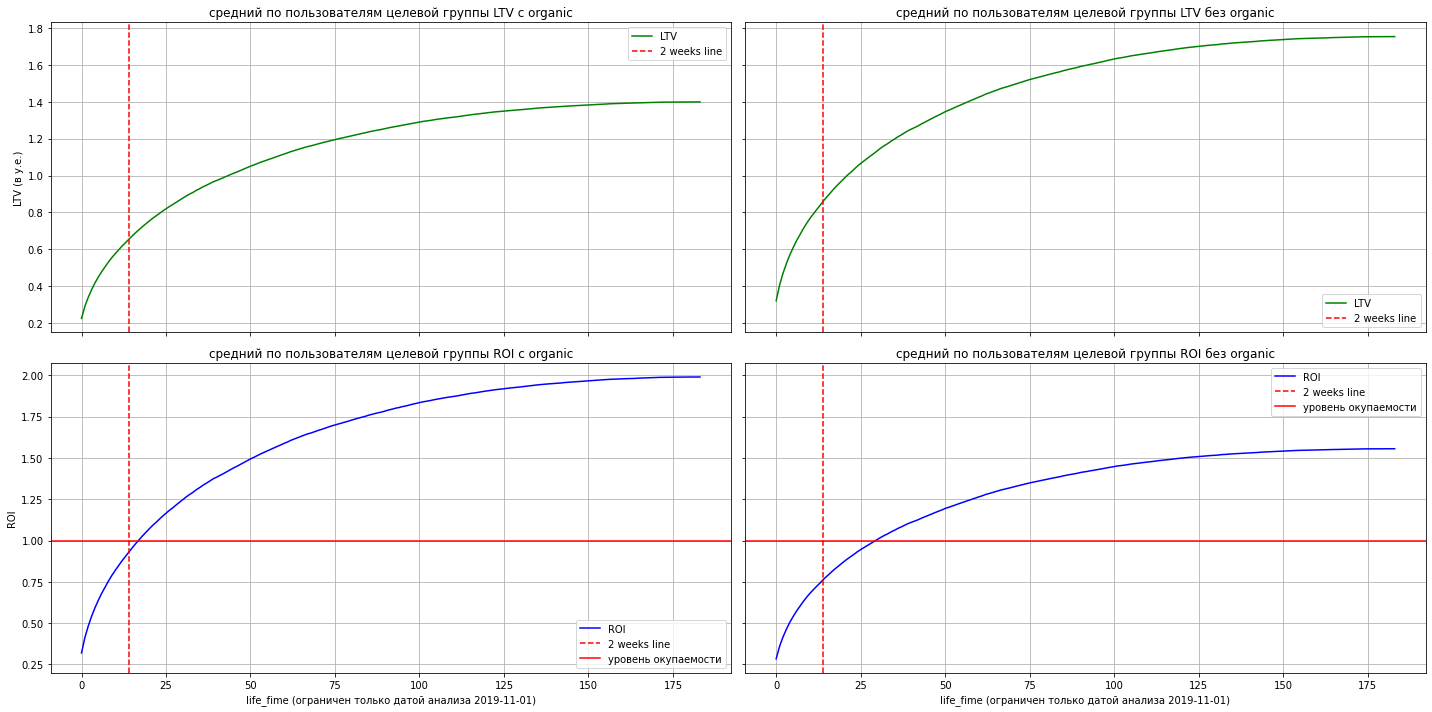

In [61]:
reporting_df = orders_df.query('cohort_dt <= @last_cohort_dt').groupby('life_time').agg({'revenue':'sum'})
reporting_df['LTV'] = reporting_df['revenue'].cumsum()/ nof_users_with_organic
reporting_df['ROI'] = reporting_df['revenue'].cumsum()/ total_pubcosts

plt.figure(figsize=(20, 10))

ax1 = plt.subplot(2,2,1)
reporting_df['LTV'].plot(kind='line', grid=True, ax=ax1, color='green')
plt.title('средний по пользователям целевой группы LTV с organic')
plt.ylabel('LTV (в у.е.)')
plt.xlabel('life_fime (ограничен только датой анализа 2019-11-01)')
plt.axvline(x=max_life_time, color='red', linestyle='--', label='2 weeks line') # отсечка окупаемости по бизнес-плану
plt.legend()

ax3 = plt.subplot(2,2,3,sharex=ax1)
reporting_df['ROI'].plot(kind='line', grid=True, ax=ax3, color='blue')
plt.title('средний по пользователям целевой группы ROI с organic')
plt.ylabel('ROI')
plt.xlabel('life_fime (ограничен только датой анализа 2019-11-01)')
plt.axvline(x=max_life_time, color='red', linestyle='--', label='2 weeks line') # отсечка времени окупаемости по бизнес-плану
plt.axhline(y=1, color='red', linestyle='-', label='уровень окупаемости') # уровень окупаемости
plt.legend()

#----------------------------------------------------------------------------------- теперь то же без organic

reporting_df = orders_df.query('cohort_dt <= @last_cohort_dt & reg_channel != "organic"').groupby('life_time').agg(
    {'revenue':'sum'})
reporting_df['LTV'] = reporting_df['revenue'].cumsum()/ nof_users_no_organic
reporting_df['ROI'] = reporting_df['revenue'].cumsum()/ total_pubcosts

ax2 = plt.subplot(2,2,2,sharey=ax1,sharex=ax1)
reporting_df['LTV'].plot(kind='line', grid=True, ax=ax2, color='green')
plt.title('средний по пользователям целевой группы LTV без organic')
plt.ylabel('LTV (в у.е.)')
plt.xlabel('life_fime (ограничен только датой анализа 2019-11-01)')
plt.axvline(x=max_life_time, color='red', linestyle='--', label='2 weeks line') # отсечка окупаемости по бизнес-плану
plt.legend()

ax4 = plt.subplot(2,2,4,sharey=ax3,sharex=ax1)
reporting_df['ROI'].plot(kind='line', grid=True, ax=ax4, color='blue')
plt.title('средний по пользователям целевой группы ROI без organic')
plt.ylabel('ROI')
plt.xlabel('life_fime (ограничен только датой анализа 2019-11-01)')
plt.axvline(x=max_life_time, color='red', linestyle='--', label='2 weeks line') # отсечка времени окупаемости по бизнес-плану
plt.axhline(y=1, color='red', linestyle='-', label='уровень окупаемости') # уровень окупаемости
plt.legend()

#--------------------------------------------------------------------- показать все графики
plt.tight_layout()
plt.show()

Как ожидалось, учет органических пользователей, хоть и ухудшает метрику LTV (так как органические пользователи покупают экономнее), но существенно улудшают метрику ROI.

#### Промежуточные выводы:
* Бизнес KPI в две недели окупаемости выбран неудачно - графики LTV показывают, что за этот период пользователи реализуют свой покупательский потенциал менее чем на 50% - особенно пользователи с платным привлечением!
* В целом компания остается в плюсе за весь целевой период, даже без органических пользователей, но метрики бизнес-плана (окупаемость за 2 недели) уже нарушены.
* Благодаря оздоровительному влиянию на прибыльность дохода от органических пользователей, в целом за весь целевой период компания вышла в минус по бизнес-показателю прибыльности совсем недавно - кривая ROI на левом нижнем графике проходит близко от точки окупаемости (time_life = 14, ROI=0.9)
* Однако затраты на маркетинг не окупаются уже давно - кривая ROI на правом нижнем графике проходит пересекает time_life = 14 на уровне ROI=0.75)

#### Когортная динамика двунедельных LTV, CAC и ROI

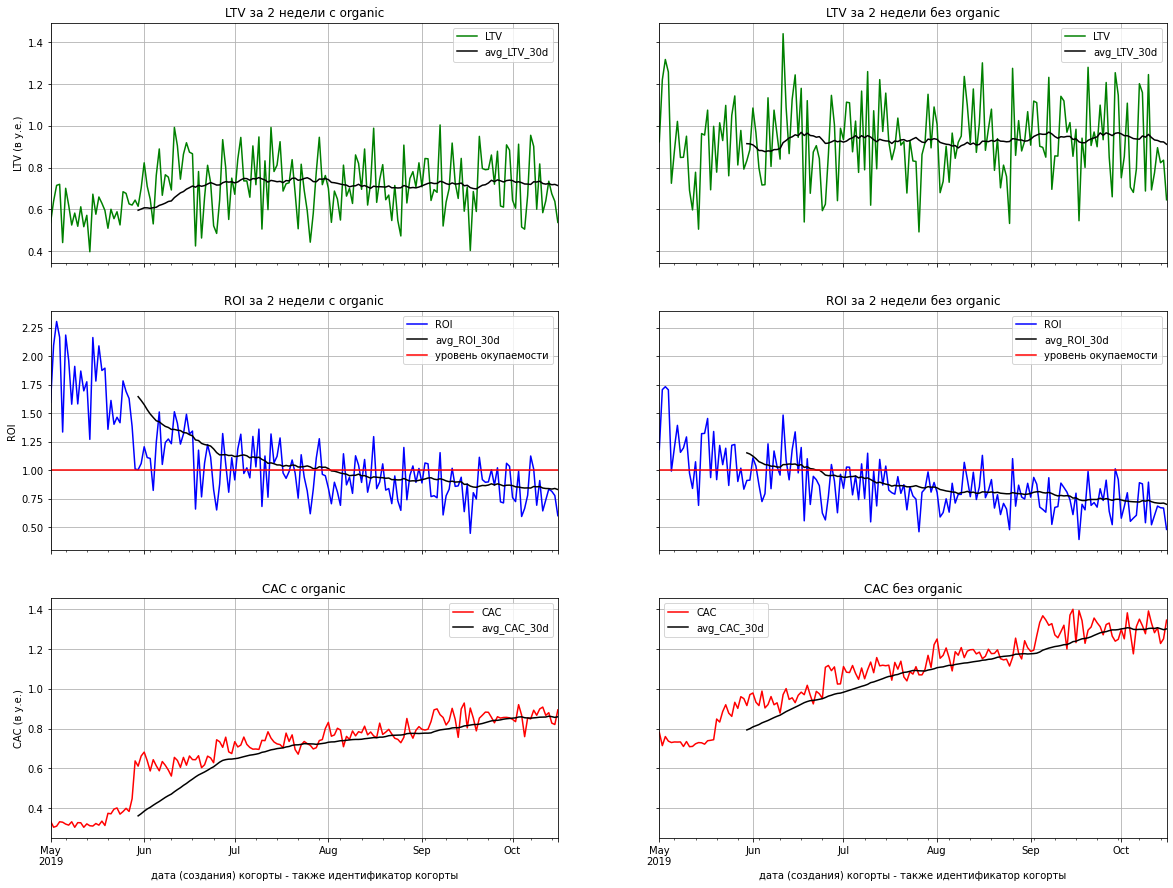

In [62]:
reporting_df = orders_df.query('cohort_dt <= @last_cohort_dt & life_time <= @max_life_time').groupby(
    ['cohort_dt'], as_index=False).agg({'revenue':'sum'}).rename(columns={'revenue':'cohort_revenue'})

reporting_df = reporting_df.merge( # пришиваем стоимость когорт
    pubcosts_df.groupby('pub_dt', as_index=False).agg({'costs':'sum'}).rename(
    columns={'pub_dt':'cohort_dt','costs':'cohort_costs'}), how='left', on='cohort_dt')

reporting_df = reporting_df.merge( # пришиваем размеры когорт
    users_df.groupby('cohort_dt', as_index=False).agg({'user_id':'nunique'}).rename(
    columns={'user_id':'cohort_size'}), how='left', on='cohort_dt')

reporting_df['LTV'] = reporting_df['cohort_revenue'] / reporting_df['cohort_size']
reporting_df['CAC'] = reporting_df['cohort_costs'] / reporting_df['cohort_size']
reporting_df['ROI'] = reporting_df['cohort_revenue'] / reporting_df['cohort_costs']
reporting_df['avg_LTV_30d'] = reporting_df['LTV'].rolling(30).mean()
reporting_df['avg_CAC_30d'] = reporting_df['CAC'].rolling(30).mean()
reporting_df['avg_ROI_30d'] = reporting_df['avg_LTV_30d'] / reporting_df['avg_CAC_30d'] 

plt.figure(figsize=(20, 15))

ax1 = plt.subplot(3,2,1)
reporting_df.plot(x='cohort_dt', y=['LTV','avg_LTV_30d'], kind='line', grid=True, ax=ax1, color=['green','black'])
plt.title('LTV за 2 недели с organic')
plt.ylabel('LTV (в у.е.)')
plt.xlabel('дата (создания) когорты - также идентификатор когорты')
plt.legend()

ax3 = plt.subplot(3,2,3,sharex=ax1)
reporting_df.plot(x='cohort_dt', y=['ROI','avg_ROI_30d'], kind='line', grid=True, ax=ax3, color=['blue','black'])
plt.title('ROI за 2 недели с organic')
plt.ylabel('ROI')
plt.xlabel('дата (создания) когорты - также идентификатор когорты')
plt.axhline(y=1, color='red', linestyle='-', label='уровень окупаемости') # уровень окупаемости
plt.legend()

ax5 = plt.subplot(3,2,5,sharex=ax1)
reporting_df.plot(x='cohort_dt', y=['CAC','avg_CAC_30d'], kind='line', grid=True, ax=ax5, color=['red','black'])
plt.title('CAC с organic')
plt.ylabel('CAC (в у.е.)')
plt.xlabel('дата (создания) когорты - также идентификатор когорты')
plt.legend()

#----------------------------------------------------------------------------------- теперь то же без organic
reporting_df = orders_df.query('cohort_dt <= @last_cohort_dt & life_time <= @max_life_time & reg_channel != "organic"').groupby(
    ['cohort_dt'], as_index=False).agg({'revenue':'sum'}).rename(columns={'revenue':'cohort_revenue'})

reporting_df = reporting_df.merge( # пришиваем стоимость когорт
    pubcosts_df.groupby('pub_dt', as_index=False).agg({'costs':'sum'}).rename(
    columns={'pub_dt':'cohort_dt','costs':'cohort_costs'}), how='left', on='cohort_dt')

reporting_df = reporting_df.merge( # пришиваем размеры когорт
    users_df.query('reg_channel != "organic"').groupby('cohort_dt', as_index=False).agg({'user_id':'nunique'}).rename(
    columns={'user_id':'cohort_size'}), how='left', on='cohort_dt')

reporting_df['LTV'] = reporting_df['cohort_revenue'] / reporting_df['cohort_size']
reporting_df['CAC'] = reporting_df['cohort_costs'] / reporting_df['cohort_size']
reporting_df['ROI'] = reporting_df['cohort_revenue'] / reporting_df['cohort_costs']
reporting_df['avg_LTV_30d'] = reporting_df['LTV'].rolling(30).mean()
reporting_df['avg_CAC_30d'] = reporting_df['CAC'].rolling(30).mean()
reporting_df['avg_ROI_30d'] = reporting_df['avg_LTV_30d'] / reporting_df['avg_CAC_30d'] 

ax2 = plt.subplot(3,2,2,sharey=ax1)
reporting_df.plot(x='cohort_dt', y=['LTV','avg_LTV_30d'], kind='line', grid=True, ax=ax2, color=['green','black'])
plt.title('LTV за 2 недели без organic')
plt.ylabel('LTV (в у.е.)')
plt.xlabel('дата (создания) когорты - также идентификатор когорты')
plt.legend()

ax4 = plt.subplot(3,2,4,sharex=ax2,sharey=ax3)
reporting_df.plot(x='cohort_dt', y=['ROI','avg_ROI_30d'], kind='line', grid=True, ax=ax4, color=['blue','black'])
plt.title('ROI за 2 недели без organic')
plt.ylabel('ROI')
plt.xlabel('дата (создания) когорты - также идентификатор когорты')
plt.axhline(y=1, color='red', linestyle='-', label='уровень окупаемости') # уровень окупаемости
plt.legend()

ax6 = plt.subplot(3,2,6,sharex=ax2,sharey=ax5)
reporting_df.plot(x='cohort_dt', y=['CAC','avg_CAC_30d'], kind='line', grid=True, ax=ax6, color=['red','black'])
plt.title('CAC без organic')
plt.ylabel('CAC (в у.е.)')
plt.xlabel('дата (создания) когорты - также идентификатор когорты')
plt.legend()

In [63]:
#--------------------------------------------------------------------- показать все графики
#plt.tight_layout()
plt.show()

**Анализ графиков**:
* График *CAC без organic* ожидаемо похож на графики расходов на маркетинг, при этом его недельная и квартальная составляющие неплохо сглажены даже без усреднения по окну в 30 дней - видимо модель привлечения пользователей - чем больше привлечено, тем больше проплачено за маркетинг действительно работает.  
* Долгосрочный тренд CAC подтверждает предположения, что затраты на привлечение одного пользователя растут, при этом двухнедельный доход с нового пользователя остается на прежнем уровне - что приводит к падению ROI:  фактически реклама перестала окупаться уже со второго месяца и только бесплатность органических абонентов не дала провалиться и первому кварталу!
* Кривые с учетом органических абонентов демонстрируют аномальное поведение в первый месяц - как будто больше всего органических абонентов было в первый месяц.  Проверим это на датасете users_df:

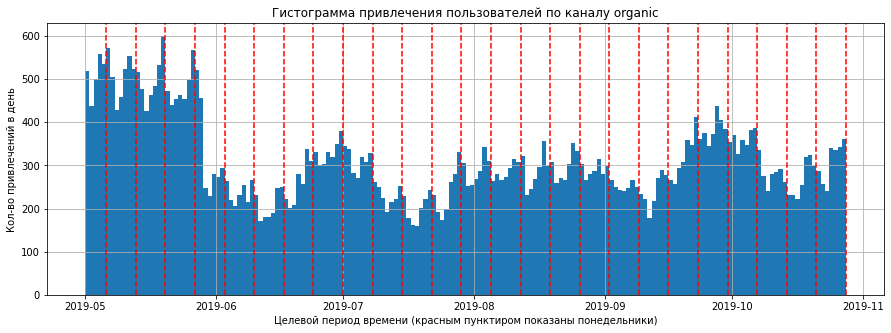

In [64]:
users_df.query('reg_channel == "organic"')['registration_dt'].hist( bins=(max_reg_dt-min_reg_dt).days+1, figsize=(15,5) )

plt.title('Гистограмма привлечения пользователей по каналу organic')
plt.ylabel('Кол-во привлечений в день')
plt.xlabel('Целевой период времени (красным пунктиром показаны понедельники)')

for d in range((max_reg_dt-min_reg_dt).days+2):
    if (min_reg_dt + timedelta(days=d)).weekday() == 0:
        plt.axvline(x=(min_reg_dt + timedelta(days=d)), color='red', linestyle='--') # ставим отметки понедельников

plt.show()

да действительно - первые 4 недели ежедневные регистрации бесплатных пользователей в среднем в 2 раза выше, чем таковые в последующий период!

#### Замечена аномалия:
по неизвестным причинам на 5-ой неделе регистрации пользователей в канале organic падают в 2 раза по среднему уровню.  Это завысило ожидания от прибыльности бизнеса в первом квартале целевого периода.

### Окупаемость рекламы с разбивкой по рекламным каналам 

#### Зависимости интегрально по всем когортам для LTV и ROI от life-time - в разбивке по каналам привлечения

определим кол-во пользователей и суммарные затраты по каналам:

In [65]:
users_per_channel = users_df.groupby('reg_channel').agg({'user_id':'count'}).rename(columns={'user_id':'nof_users'})
costs_per_channel = pubcosts_df.groupby('channel').agg({'costs':'sum'})

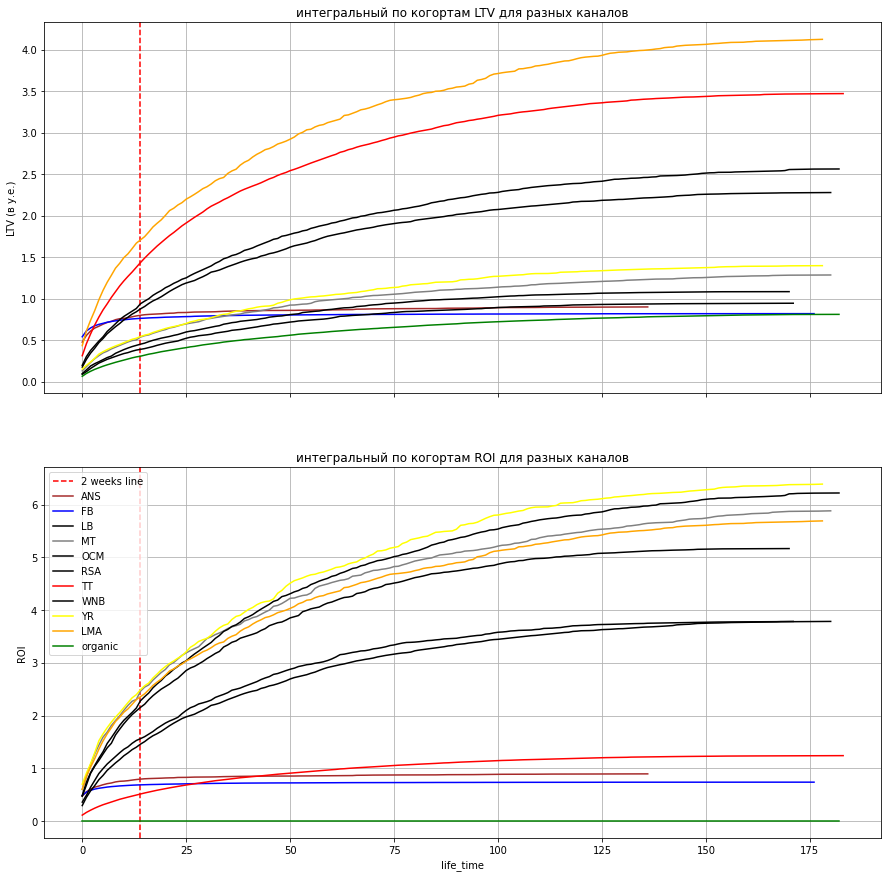

In [66]:
plt.figure(figsize=(15, 15))

ax1 = plt.subplot(2,1,1)

plt.title('интегральный по когортам LTV для разных каналов')
plt.ylabel('LTV (в у.е.)')
plt.xlabel('life_fime (ограничен только датой анализа 2019-11-01 и горизонтом в 2 недели)')
plt.axvline(x=max_life_time, color='red', linestyle='--', label='2 weeks line') # отсечка окупаемости по бизнес-плану

ax2 = plt.subplot(2,1,2,sharex=ax1)

plt.title('интегральный по когортам ROI для разных каналов')
plt.ylabel('ROI')
plt.xlabel('life_fime (ограничен только датой анализа 2019-11-01 и горизонтом в 2 недели)')
plt.axvline(x=max_life_time, color='red', linestyle='--', label='2 weeks line') # отсечка окупаемости по бизнес-плану

color_dict = {
    'AdNonSense':'brown',
    'FaceBoom':'blue',
    'LeapBob':'black',
    'MediaTornado':'gray',
    'OppleCreativeMedia':'black',
    'RocketSuperAds':'black',
    'TipTop': 'red',
    'WahooNetBanner':'black',
    'YRabbit':'yellow',
    'lambdaMediaAds':'orange',
    'organic':'green'
}

for ch in list(users_per_channel.index): # будем в цикле по каналам рисовать их LTV и ROI разными цветами

    reporting_df = orders_df.query('cohort_dt <= @last_cohort_dt & reg_channel == @ch').groupby('life_time').agg(
        {'revenue':'sum'})
    reporting_df['LTV'] = reporting_df['revenue'].cumsum() / users_per_channel.loc[ch,'nof_users']
    if ch == 'organic':
        reporting_df['ROI'] = reporting_df['revenue'].cumsum() / 1_000_000_000_000
    else:
        reporting_df['ROI'] = reporting_df['revenue'].cumsum() / costs_per_channel.loc[ch,'costs']

    reporting_df['LTV'].plot(kind='line', grid=True, ax=ax1, color=color_dict[ch], label=ch_abbr[ch])

    reporting_df['ROI'].plot(kind='line', grid=True, ax=ax2, color=color_dict[ch], label=ch_abbr[ch])
    
plt.legend()
plt.show()

#### Промежуточные выводы:
* Бизнес KPI в две недели окупаемости выбран неудачно - графики LTV показывают, что за этот период пользователи реализуют свой покупательский потенциал менее чем на 30-50% - особенно пользователи с платным привлечением (за исключением FaceBoom и AdNonSense)!
* Оба самых крупных канала маркетинга (TipTop и FaceBoom) убыточны при KPI прибыльности за 2 недели.  При этом TipTop все же выходит на минимальную окупаемость на сроках порядка 8 недель - максимальная ROI = 1.3, а вот BaceBoom не окупается совсем - максимальная ROI = 0.7, причем, выход на насыщение происходит за первую неделю.  Это самый "скорострельный" канал - явно какие-то проблемы с удержанием, или с размещением повторных заказов.  Возможно на канале FaceBoom регистрация каждый раз происходит заново, проверим сколько там повторных заказов.
* Самым выгодным каналом является YRabbit (ROI насыщается при 6.4), но, видимо, за счет низких тарифов - LTV его абонентов не высок (LTV насыщается при 1.4 у.е.).
* Самам оптимальным каналом является канал lambdaMediaAds - при немногим уступающем уровне насыщения ROI = 5.7, его LTV самый высокий (LTV насыщается при 4.2 у.е.)
* Самым плохим оказался канал AdNonSense - единственный убыточный среди малобюджетных, причем как по KPI = 2 недели, так и по неограниченному life_time.  Это второй канал с проблемой "скорострельности" - после FaceBoom
* В целом все малобюджетные каналы, кроме AdNonSense, показывают хорошую прибыльность (остальные показаны черным на графиках, из-за проблем с различением слишком большого кол-ва цветов)

In [67]:
# посмотрим на скорострельность FaceBoom
# гипотеза была, что у него по каким-то причинам нет/мало повторных заказов

print('Доля повторных заказов для FaceBoom', 
      round(100*orders_df.query('reg_channel == "FaceBoom"')['user_id'].duplicated(
      ).sum()/orders_df.query('reg_channel == "FaceBoom"')['user_id'].count(),1), '%')

print('Доля повторных заказов для всех платных каналов кроме FaceBoom', 
      round(100*orders_df.query('reg_channel not in ["organic","FaceBoom"]')['user_id'].duplicated(
      ).sum()/orders_df.query('reg_channel not in ["organic","FaceBoom"]')['user_id'].count(),1), '%')

Доля повторных заказов для FaceBoom 24.9 %
Доля повторных заказов для всех платных каналов кроме FaceBoom 84.5 %


Повторные заказы на FaceBoom все же есть - их делает каждый 4-й купивший первый заказ, но это разительно отличается от других платных каналов - там их делают 5 из 6 купивших в первый раз!

Проблемы FaceBoom надо будет исследовать пристальнее - **вторая зацепка!**

(как мы уже отмечали, AdNonSense также испытывает похожие проблемы, но поскольку он малобюджетный, рекомендацией нулевого приближения будет отказаться от их услуг, либо предложить им найти самим свою проблему.  А вот за FaceBoom нужно побороться - его влияние на прибыльность велико!)

#### Когортная динамика двунедельных LTV, CAC и ROI - в разбивке по каналам привлечения

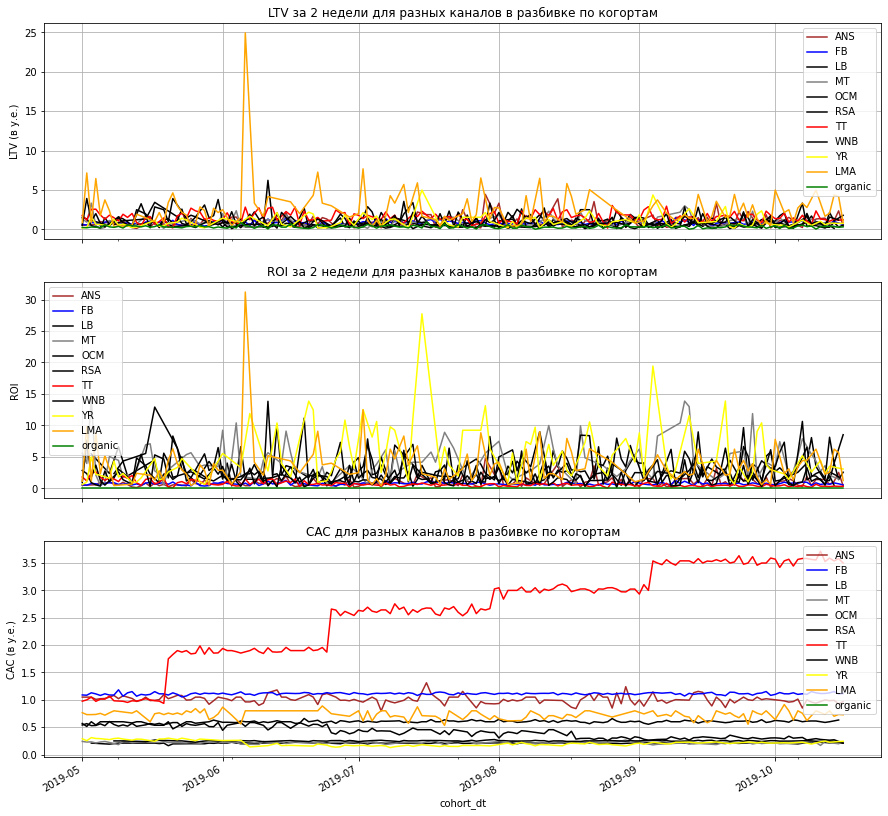

In [68]:
plt.figure(figsize=(15, 15))

ax1 = plt.subplot(3,1,1)

plt.title('LTV за 2 недели для разных каналов в разбивке по когортам')
plt.ylabel('LTV (в у.е.)')
plt.xlabel('дата (создания) когорты - также идентификатор когорты')

ax2 = plt.subplot(3,1,2,sharex=ax1)

plt.title('ROI за 2 недели для разных каналов в разбивке по когортам')
plt.ylabel('ROI')
plt.xlabel('дата (создания) когорты - также идентификатор когорты')

ax3 = plt.subplot(3,1,3,sharex=ax1)

plt.title('CAC для разных каналов в разбивке по когортам')
plt.ylabel('CAC (в у.е.)')
plt.xlabel('дата (создания) когорты - также идентификатор когорты')

for ch in list(users_per_channel.index): # будем в цикле по каналам рисовать их LTV и ROI разными цветами

    reporting_df = orders_df.query(
        'cohort_dt <= @last_cohort_dt & life_time <= @max_life_time & reg_channel == @ch'
        ).groupby(['cohort_dt'], as_index=False).agg({'revenue':'sum'}).rename(columns={'revenue':'cohort_revenue'})
    
    reporting_df = reporting_df.merge( # пришиваем стоимость когорт
        pubcosts_df.query(
            'channel == @ch & pub_dt <= @last_cohort_dt'
            ).groupby('pub_dt', as_index=False).agg({'costs':'sum'}).rename(
                columns={'pub_dt':'cohort_dt','costs':'cohort_costs'}), how='left', on='cohort_dt')
    
    reporting_df = reporting_df.merge( # пришиваем размеры когорт
        users_df.query(
            'reg_channel == @ch & cohort_dt <= @last_cohort_dt'
            ).groupby('cohort_dt', as_index=False).agg({'user_id':'nunique'}).rename(
                columns={'user_id':'cohort_size'}), how='left', on='cohort_dt')

    reporting_df['LTV'] = reporting_df['cohort_revenue'] / reporting_df['cohort_size']
    reporting_df['CAC'] = reporting_df['cohort_costs'] / reporting_df['cohort_size']
    if ch == 'organic':
        reporting_df['ROI'] = reporting_df['cohort_revenue'].cumsum() / 1_000_000_000_000
    else:
        reporting_df['ROI'] = reporting_df['cohort_revenue'] / reporting_df['cohort_costs']
    
    reporting_df.plot(x='cohort_dt', y='LTV', kind='line', grid=True, ax=ax1, color=color_dict[ch], label=ch_abbr[ch])

    reporting_df.plot(x='cohort_dt', y='ROI', kind='line', grid=True, ax=ax2, color=color_dict[ch], label=ch_abbr[ch])

    reporting_df.plot(x='cohort_dt', y='CAC', kind='line', grid=True, ax=ax3, color=color_dict[ch], label=ch_abbr[ch])

plt.legend()
#plt.tight_layout()
plt.show()

**Анализ графиков**:
* Примерно раз в месяц партнер TipTop скачкообразно повышает нам тариф оплаты рекламы, причем очень точно следуя насыщению ROI на уровне 1.3.  Дает нам дышать, но забирает все излишки - как будто у нас оплата по revenue share.

Сгладим LTV и ROI скользящим окном, а в CAC сделаем zoom без TipTop (с TipTop все ясно уже на этом графике CAC, но на его фоне других не видно!):

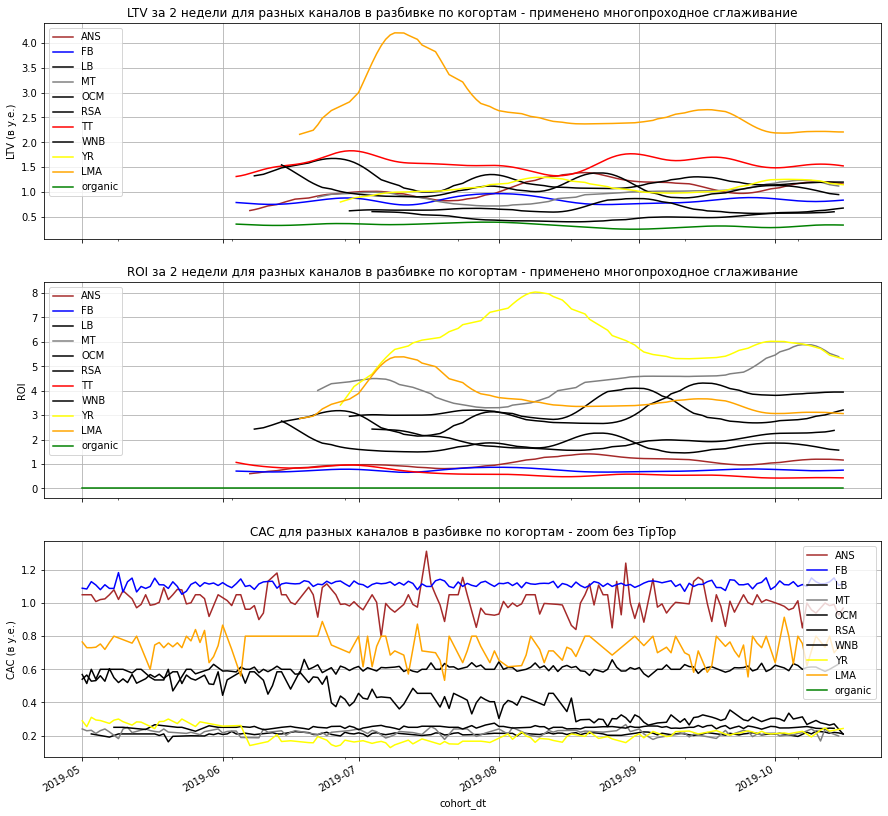

In [69]:
plt.figure(figsize=(15, 15))

ax1 = plt.subplot(3,1,1)

plt.title('LTV за 2 недели для разных каналов в разбивке по когортам - применено многопроходное сглаживание')
plt.ylabel('LTV (в у.е.)')
plt.xlabel('дата (создания) когорты - также идентификатор когорты')

ax2 = plt.subplot(3,1,2,sharex=ax1)

plt.title('ROI за 2 недели для разных каналов в разбивке по когортам - применено многопроходное сглаживание')
plt.ylabel('ROI')
plt.xlabel('дата (создания) когорты - также идентификатор когорты')

ax3 = plt.subplot(3,1,3,sharex=ax1)

plt.title('CAC для разных каналов в разбивке по когортам - zoom без TipTop')
plt.ylabel('CAC (в у.е.)')
plt.xlabel('дата (создания) когорты - также идентификатор когорты')

for ch in list(users_per_channel.index): # будем в цикле по каналам рисовать их LTV и ROI разными цветами

    reporting_df = orders_df.query(
        'cohort_dt <= @last_cohort_dt & life_time <= @max_life_time & reg_channel == @ch'
        ).groupby(['cohort_dt'], as_index=False).agg({'revenue':'sum'}).rename(
            columns={'revenue':'cohort_revenue'}) # суммируем за 2 нед.
    
    reporting_df = reporting_df.merge( # пришиваем стоимость когорт
        pubcosts_df.query(
            'channel == @ch & pub_dt <= @last_cohort_dt'
            ).groupby('pub_dt', as_index=False).agg({'costs':'sum'}).rename(
                columns={'pub_dt':'cohort_dt','costs':'cohort_costs'}), how='left', on='cohort_dt')
    
    reporting_df = reporting_df.merge( # пришиваем размеры когорт
        users_df.query(
            'reg_channel == @ch & cohort_dt <= @last_cohort_dt'
            ).groupby('cohort_dt', as_index=False).agg({'user_id':'nunique'}).rename(
                columns={'user_id':'cohort_size'}), how='left', on='cohort_dt')

    reporting_df['LTV'] = (reporting_df['cohort_revenue'] / reporting_df['cohort_size']).rolling(3).mean(
        ).rolling(5).mean().rolling(7).mean().rolling(11).mean().rolling(13).mean()
    reporting_df['CAC'] = (reporting_df['cohort_costs'] / reporting_df['cohort_size'])
    if ch == 'organic':
        reporting_df['ROI'] = reporting_df['cohort_revenue'].cumsum() / 1_000_000_000_000
    else:
        reporting_df['ROI'] = (reporting_df['cohort_revenue'] / reporting_df['cohort_costs']).rolling(3).mean(
        ).rolling(5).mean().rolling(7).mean().rolling(11).mean().rolling(13).mean()
# пришлось сделать многопроходное сглаживание с переменным периодом, представляющим простые числа (чтобы не поймать стробоскоп)
    
    reporting_df.plot(x='cohort_dt', y='LTV', kind='line', grid=True, ax=ax1, color=color_dict[ch], label=ch_abbr[ch])

    reporting_df.plot(x='cohort_dt', y='ROI', kind='line', grid=True, ax=ax2, color=color_dict[ch], label=ch_abbr[ch])

    if ch != 'TipTop':
        reporting_df.plot(x='cohort_dt', y='CAC', kind='line', grid=True, ax=ax3, color=color_dict[ch], label=ch_abbr[ch])

plt.legend()
#plt.tight_layout()
plt.show()

#### Промежуточные выводы:
* Когортный анализ подтвердил выводы про хорошие и плохие каналы, сделанные при анализе интегральных по когортам метрик в каналах.
* При когортном анализе обнаружен инсайд (либо техническая утечка данных) в сторону партнера TipTop о доходности пользователей, привлеченных по каналу партнера. В результате партнер повышает тарифы на привлечение новых пользователей, занижая нашу прибыльность.  **Третья зацепка!** 

### Окупаемость рекламы с разбивкой по странам (TBD)

К сожалению, информация о маркетинговых выплатах не содержит никакой привязки к странам, но быть может конкретные маркетинговые партнеры работают только в конкретной стране - проверим:

In [70]:
for ch in list(set(list(users_df['reg_channel']))):
    print(ch.ljust(20), set(list(users_df.query('reg_channel == @ch')['country'])))

TipTop               {'United States'}
FaceBoom             {'United States'}
lambdaMediaAds       {'France', 'UK', 'Germany'}
organic              {'France', 'Germany', 'United States', 'UK'}
RocketSuperAds       {'United States'}
OppleCreativeMedia   {'France', 'UK', 'Germany'}
LeapBob              {'France', 'Germany', 'UK'}
YRabbit              {'United States'}
AdNonSense           {'France', 'Germany', 'UK'}
WahooNetBanner       {'France', 'UK', 'Germany'}
MediaTornado         {'United States'}


Неплохая попытка - в отношении США 5 маркетинговых партнеров работают с ними и только с ними, поэтому выделить косты рекламы, которые даны только в привязке к дню оплаты и к каналу можно только для США.  По остальным странам - Англии, Германии и Франции - маркетинговые косты известны только в сумме, без детальной разбивки.

#### Объективные ограничения при анализе окупаемости по странам:
* исходные данные позволяют проанализировать по каждой отдельной стране только LTV;
* в отношении CAC и ROI мы можем только посмотреть отдельно на США и на Европу, без разбивки последней на три страны

#### Анализ LTV в разбивке на страны
для него годится тот же датасет, что и для разбивки по каналам - только вместо channel будет country.  Также восстанавливаем два столбца визуализации графиков - с учетов органичных пользователей и без них.

In [71]:
orders_df

user_id            order_dt  revenue     registration_dt  \
0      188246423999 2019-05-01 23:09:52     4.99 2019-05-01 23:09:42   
1      174361394180 2019-05-01 12:24:04     4.99 2019-05-01 12:23:47   
2      529610067795 2019-05-01 11:34:04     4.99 2019-05-01 11:33:56   
3      319939546352 2019-05-01 15:34:40     4.99 2019-05-01 15:34:15   
4      366000285810 2019-05-01 13:59:51     4.99 2019-05-01 13:59:01   
...             ...                 ...      ...                 ...   
40207  651604369137 2019-10-31 16:19:07     4.99 2019-10-25 23:05:18   
40208  275341387049 2019-10-31 01:17:17     4.99 2019-10-25 16:24:20   
40209  374656616484 2019-10-31 06:17:29     4.99 2019-10-26 18:41:49   
40210  168548862926 2019-10-31 22:46:19     4.99 2019-10-27 15:14:36   
40211  329994900775 2019-10-31 13:29:06     4.99 2019-10-27 18:17:40   

              reg_channel reg_device        country  cohort_dt  life_time  
0                FaceBoom    Android  United States 2019-05-01          0  
1          RocketSuperAds     iPhone  United States 2019-05-01          0  
2                FaceBoom        Mac  United States 2019-05-01          0  
3                FaceBoom    Android  United States 2019-05-01          0  
4                FaceBoom     iPhone  United States 2019-05-01          0  
...                   ...        ...            ...        ...        ...  
40207      lambdaMediaAds     iPhone         France 2019-10-25          5  
40208      WahooNetBanner         PC         France 2019-10-25          5  
40209  OppleCreativeMedia    Android             UK 2019-10-26          4  
40210          AdNonSense         PC         France 2019-10-27          4  
40211             LeapBob         PC             UK 2019-10-27          3  

[40212 rows x 9 columns]

##### Зависимости интегрально по всем когортам для LTV от life-time - в разбивке всем странам

In [72]:
users_per_country_with_organic = users_df.groupby('country').agg({'user_id':'count'}).rename(columns={'user_id':'nof_users'})
users_per_country_no_organic = users_df.query('reg_channel != "organic"').groupby('country').agg({'user_id':'count'}).rename(
                               columns={'user_id':'nof_users'})

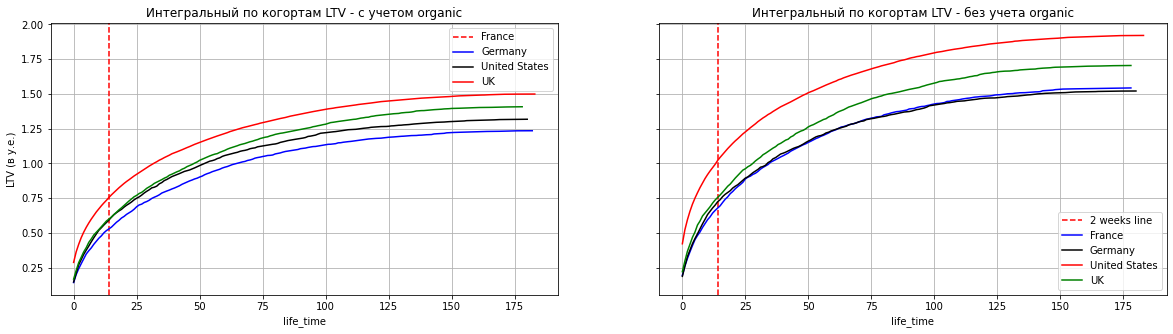

In [73]:
plt.figure(figsize=(20, 5))

ax1 = plt.subplot(1,2,1)
plt.title('Интегральный по когортам LTV - с учетом organic')
plt.ylabel('LTV (в у.е.)')
plt.xlabel('дата (создания) когорты - также идентификатор когорты')
plt.axvline(x=max_life_time, color='red', linestyle='--', label='2 weeks line') # отсечка окупаемости по бизнес-плану

ax2 = plt.subplot(1,2,2,sharey=ax1)
plt.title('Интегральный по когортам LTV - без учета organic')
plt.ylabel('LTV (в у.е.)')
plt.xlabel('дата (создания) когорты - также идентификатор когорты')
plt.axvline(x=max_life_time, color='red', linestyle='--', label='2 weeks line') # отсечка окупаемости по бизнес-плану

cn_color_dict = {
    'United States':'red',
    'UK':'green',
    'France':'blue',
    'Germany':'black'
}

for cn in list(set(list(users_df['country']))):

    reporting_df = orders_df.query(
        'country == @cn'
        ).groupby(['life_time'], as_index=False).agg({'revenue':'sum'}).rename(columns={'revenue':'cohort_revenue'})
    
    reporting_df['LTV'] = reporting_df['cohort_revenue'].cumsum() / users_per_country_with_organic.loc[cn,'nof_users']
    
    reporting_df.plot(x='life_time', y='LTV', kind='line', grid=True, color=cn_color_dict[cn], label=cn, ax=ax1)
 
    reporting_df = orders_df.query(
        'country == @cn & reg_channel != "organic"'
        ).groupby(['life_time'], as_index=False).agg({'revenue':'sum'}).rename(columns={'revenue':'cohort_revenue'})
    
    reporting_df['LTV'] = reporting_df['cohort_revenue'].cumsum() / users_per_country_no_organic.loc[cn,'nof_users']
        
    reporting_df.plot(x='life_time', y='LTV', kind='line', grid=True, color=cn_color_dict[cn], label=cn, ax=ax2)


plt.legend()
#plt.tight_layout()
plt.show()

##### Когортная динамика двунедельных LTV - в разбивке по всем странам

**Анализ графиков**:
* У США виден стартовый гандикап по сравнению со всеми европейскими странами, который США сохраняют и дальше, в остальном кривые похожи; 
* Данный гандикап состоит из среднего по пользователю заказа дня регистрации - по платным пользователям он составляет порядка 0.25 у.е. (правый график).  Но с учетом уже обнаруженного роста CAC у канала TipTop (действует только в США), такого гандикапа может нехватить, и по ROI США могут оказаться хуже Европы, особенно во втором квартале целевого периода;
* Среди европейских каналов лучше выглядит Англия, но мы не сможеи подтвердить это и для ROI, так как CAC нам известен как lumpsum по всей Европе;
* самые малопокупающие органические пользователи во Франции - на графике с учетом organic Франция отстает от Германии - тогда как без органики они почти неразличимы - видимо эффект массовой эмиграции из СССР в Германию (наши органичнее!)

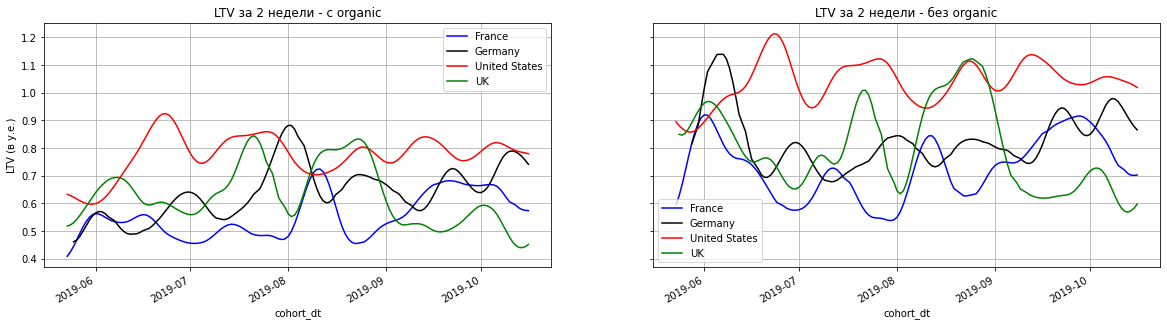

In [74]:
plt.figure(figsize=(20, 5))

ax1 = plt.subplot(1,2,1)
plt.title('LTV за 2 недели - с organic')
plt.ylabel('LTV (в у.е.)')
plt.xlabel('дата (создания) когорты - также идентификатор когорты')

ax2 = plt.subplot(1,2,2,sharey=ax1)
plt.title('LTV за 2 недели - без organic')
plt.ylabel('LTV (в у.е.)')
plt.xlabel('дата (создания) когорты - также идентификатор когорты')

cn_color_dict = {
    'United States':'red',
    'UK':'green',
    'France':'blue',
    'Germany':'black'
}

for cn in list(set(list(users_df['country']))):

    reporting_df = orders_df.query(
        'cohort_dt <= @last_cohort_dt & life_time <= @max_life_time & country == @cn'
        ).groupby(['cohort_dt'], as_index=False).agg({'revenue':'sum'}).rename(columns={'revenue':'cohort_revenue'})
    
    reporting_df= reporting_df.merge( # пришиваем размеры когорт
        users_df.query(
            'country == @cn & cohort_dt <= @last_cohort_dt'
            ).groupby('cohort_dt', as_index=False).agg({'user_id':'nunique'}).rename(
                columns={'user_id':'cohort_size'}), how='left', on='cohort_dt')
    
    reporting_df['LTV'] = (reporting_df['cohort_revenue'] / reporting_df['cohort_size']).rolling(3).mean(
        ).rolling(5).mean().rolling(7).mean().rolling(11).mean()
    
    reporting_df.plot(x='cohort_dt', y='LTV', kind='line', grid=True, color=cn_color_dict[cn], label=cn, ax=ax1)
 
    reporting_df = orders_df.query(
        'cohort_dt <= @last_cohort_dt & life_time <= @max_life_time & country == @cn & reg_channel != "organic"'
        ).groupby(['cohort_dt'], as_index=False).agg({'revenue':'sum'}).rename(columns={'revenue':'cohort_revenue'})
    
    reporting_df= reporting_df.merge( # пришиваем размеры когорт
        users_df.query(
            'country == @cn & cohort_dt <= @last_cohort_dt & reg_channel != "organic"'
        ).groupby('cohort_dt', as_index=False).agg({'user_id':'nunique'}).rename(
            columns={'user_id':'cohort_size'}), how='left', on='cohort_dt')
    
    reporting_df['LTV'] = (reporting_df['cohort_revenue'] / reporting_df['cohort_size']).rolling(3).mean(
        ).rolling(5).mean().rolling(7).mean().rolling(11).mean()
    
    reporting_df.plot(x='cohort_dt', y='LTV', kind='line', grid=True, color=cn_color_dict[cn], label=cn, ax=ax2)


plt.legend()
#plt.tight_layout()
plt.show()

**Анализ графиков**:
* Нечего добавить нового к анализу интегральных по когортам графиков с разверткой по life-time;
* Ну кроме того, что в первый месяц США еще не вышли на свой уровень продаж.

#### Анализ CAC и ROI в США и в Европе
придется добавить во все используемые датасеты столбец 'is_usa' и использовать его вместо параметра 'country':

In [75]:
orders_df['is_usa'] = orders_df['country'] == 'United States'

users_df['is_usa'] = users_df['country'] == 'United States'

def line_f(s): return (s in ['RocketSuperAds','YRabbit','FaceBoom','TipTop','MediaTornado'])
pubcosts_df['is_usa'] = pubcosts_df['channel'].apply(line_f) 

##### Зависимости интегрально по всем когортам для ROI от life-time - в США и в Европе

In [76]:
costs_per_continent = pubcosts_df.groupby('is_usa').agg({'costs':'sum'})

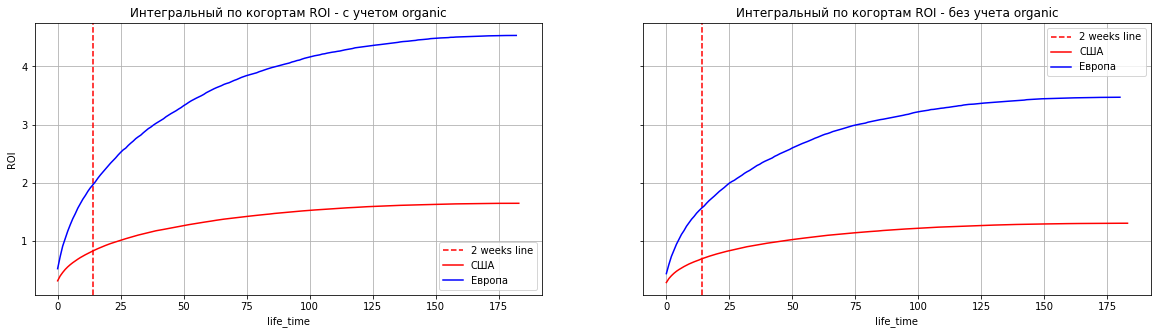

In [77]:
plt.figure(figsize=(20, 5))

ax1 = plt.subplot(1,2,1)
plt.title('Интегральный по когортам ROI - с учетом organic')
plt.ylabel('ROI')
plt.xlabel('дата (создания) когорты - также идентификатор когорты')
plt.axvline(x=max_life_time, color='red', linestyle='--', label='2 weeks line') # отсечка окупаемости по бизнес-плану
plt.legend()

ax2 = plt.subplot(1,2,2,sharey=ax1)
plt.title('Интегральный по когортам ROI - без учета organic')
plt.ylabel('ROI')
plt.xlabel('дата (создания) когорты - также идентификатор когорты')
plt.axvline(x=max_life_time, color='red', linestyle='--', label='2 weeks line') # отсечка окупаемости по бизнес-плану
plt.legend()

color={}
color[True]='red'
color[False]='blue'
label={}
label[True]='США'
label[False]='Европа'

for usa in [True,False]:

    reporting_df = orders_df.query(
        'is_usa == @usa'
        ).groupby(['life_time'], as_index=False).agg({'revenue':'sum'}).rename(columns={'revenue':'cohort_revenue'})
    
    reporting_df['ROI'] = reporting_df['cohort_revenue'].cumsum() / costs_per_continent.loc[usa,'costs']
    
    reporting_df.plot(x='life_time', y='ROI', kind='line', grid=True, color=color[usa], label=label[usa], ax=ax1)
 
    reporting_df = orders_df.query(
        'is_usa == @usa & reg_channel != "organic"'
        ).groupby(['life_time'], as_index=False).agg({'revenue':'sum'}).rename(columns={'revenue':'cohort_revenue'})
    
    reporting_df['ROI'] = reporting_df['cohort_revenue'].cumsum() / costs_per_continent.loc[usa,'costs']
    
    reporting_df.plot(x='life_time', y='ROI', kind='line', grid=True, color=color[usa], label=label[usa], ax=ax2)


plt.legend()
#plt.tight_layout()
plt.show()

**Анализ графиков**:
* хотя оба континента выходят на окупаемость, Европа укладывается в бизнес KPI 2 недели - даже без учета органических пользователей, а США не укладываются в 2 недели - даже с учетом органических пользователей
* и тем не менее для Европы бизнес KPI выбран еще более неудачно, чем для США - покупательский потенциал европейского пользователя на 130% выше достигаемого на вторую неделю.  В США - только на 70%, но тоже выше (с учетом всех пользователей)

##### Когортная динамика двунедельной ROI и CAC - в США и в Европе

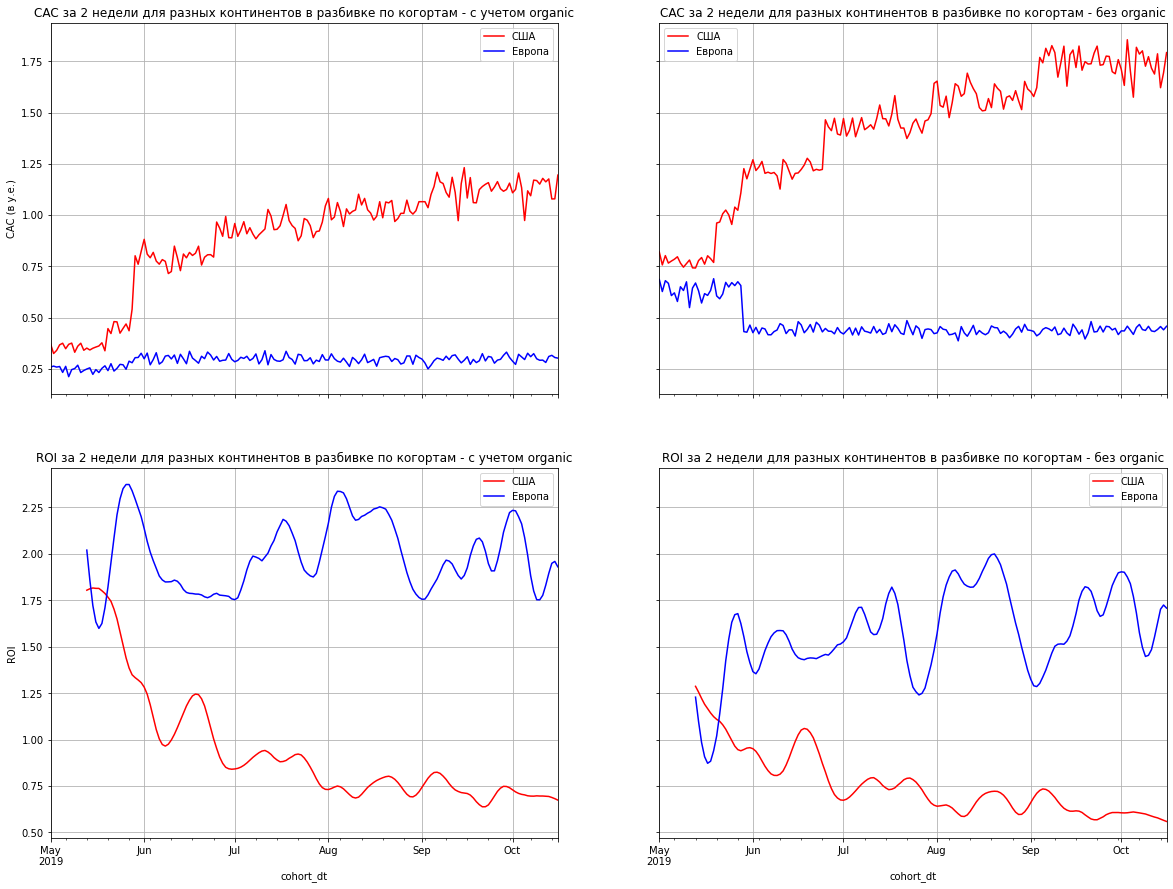

In [78]:
plt.figure(figsize=(20, 15))

ax1 = plt.subplot(2,2,1)

plt.title('CAC за 2 недели для разных континентов в разбивке по когортам - с учетом organic')
plt.ylabel('CAC (в у.е.)')
plt.xlabel('дата (создания) когорты - также идентификатор когорты')

ax2 = plt.subplot(2,2,2, sharey=ax1)

plt.title('CAC за 2 недели для разных континентов в разбивке по когортам - без organic')
plt.ylabel('CAC (в у.е.)')
plt.xlabel('дата (создания) когорты - также идентификатор когорты')

ax3 = plt.subplot(2,2,3,sharex=ax1)

plt.title('ROI за 2 недели для разных континентов в разбивке по когортам - с учетом organic')
plt.ylabel('ROI')
plt.xlabel('дата (создания) когорты - также идентификатор когорты')

ax4 = plt.subplot(2,2,4,sharex=ax2,sharey=ax3)

plt.title('ROI за 2 недели для разных континентов в разбивке по когортам - без organic')
plt.ylabel('ROI')
plt.xlabel('дата (создания) когорты - также идентификатор когорты')

color={}
color[True]='red'
color[False]='blue'
label={}
label[True]='США'
label[False]='Европа'

for usa in [True,False]:
#--------------------------------------------------------------------------------------------- сперва c organic
    reporting_df = orders_df.query(
        'cohort_dt <= @last_cohort_dt & life_time <= @max_life_time & is_usa == @usa'
        ).groupby(['cohort_dt'], as_index=False).agg({'revenue':'sum'}).rename(
            columns={'revenue':'cohort_revenue'}) 
    
    reporting_df = reporting_df.merge(
        pubcosts_df.query(
            'pub_dt <= @last_cohort_dt & is_usa == @usa'
            ).groupby('pub_dt', as_index=False).agg({'costs':'sum'}).rename(
                columns={'pub_dt':'cohort_dt','costs':'cohort_costs'}), how='left', on='cohort_dt')
    
    reporting_df = reporting_df.merge(
        users_df.query(
            'cohort_dt <= @last_cohort_dt & is_usa == @usa'
            ).groupby('cohort_dt', as_index=False).agg({'user_id':'nunique'}).rename(
                columns={'user_id':'cohort_size'}), how='left', on='cohort_dt')

    reporting_df['CAC'] = (reporting_df['cohort_costs'] / reporting_df['cohort_size'])
    
    reporting_df['ROI'] = (reporting_df['cohort_revenue'] / reporting_df['cohort_costs']).rolling(3).mean(
        ).rolling(5).mean().rolling(7).mean() #.rolling(11).mean().rolling(13).mean()
    
    reporting_df.plot(x='cohort_dt', y='CAC', kind='line', grid=True, ax=ax1, color=color[usa], label=label[usa])

    reporting_df.plot(x='cohort_dt', y='ROI', kind='line', grid=True, ax=ax3, color=color[usa], label=label[usa])
    
#-----------------------------------------------------------------------------------------теперь без organic
    reporting_df = orders_df.query(
        'cohort_dt <= @last_cohort_dt & life_time <= @max_life_time & is_usa == @usa & reg_channel != "organic"'
        ).groupby(['cohort_dt'], as_index=False).agg({'revenue':'sum'}).rename(
            columns={'revenue':'cohort_revenue'}) 
    
    reporting_df = reporting_df.merge(
        pubcosts_df.query(
            'pub_dt <= @last_cohort_dt & is_usa == @usa & channel != "organic"' # хотя тут и нет их
        ).groupby('pub_dt', as_index=False).agg({'costs':'sum'}).rename(
                columns={'pub_dt':'cohort_dt','costs':'cohort_costs'}), how='left', on='cohort_dt')
    
    reporting_df = reporting_df.merge(
        users_df.query(
            'cohort_dt <= @last_cohort_dt & is_usa == @usa & reg_channel != "organic"'
            ).groupby('cohort_dt', as_index=False).agg({'user_id':'nunique'}).rename(
                columns={'user_id':'cohort_size'}), how='left', on='cohort_dt')

    reporting_df['CAC'] = (reporting_df['cohort_costs'] / reporting_df['cohort_size'])
    
    reporting_df['ROI'] = (reporting_df['cohort_revenue'] / reporting_df['cohort_costs']).rolling(3).mean(
        ).rolling(5).mean().rolling(7).mean() #.rolling(11).mean().rolling(13).mean()
    
    reporting_df.plot(x='cohort_dt', y='CAC', kind='line', grid=True, ax=ax2, color=color[usa], label=label[usa])

    reporting_df.plot(x='cohort_dt', y='ROI', kind='line', grid=True, ax=ax4, color=color[usa], label=label[usa])
    
    
plt.legend()
#plt.tight_layout()
plt.show()

**Анализ графиков**:
* Двунедельный ROI в США быстро становится убыточным - по мере взвинчивания расценок самого крупного маркетингового канала TipTop.  Видимо, TipTop взвинчивает цены отслеживая интегральный показатель прибыльности. 
* В Европе все когорты кроме первого месяца прибыльны примерно одинаково.  В первый месяц замечена аномалия, которая хорошо коррелирует с подтвержденной ранее аномалией - в первый месяц кол-во органических пользователей на десятки процентов выше, чем потом. 
* Данный **график позволяет определить причину данной аномалии** - как видим CAC Европы с учетом все пользователей практически ровный, а CAC платных европейских пользователей ведет себя также аномально, как кол-во органических пользователей.  Это значит, что в первый месяц часть платных пользователей по европейским каналам была учтена как органические, при том, что косты на маркетинг содержали оплату их регистрации!
* Поэтому мнимо-убыточный европейский ROI первого месяца без органических пользователей - просто ошибка учета пользователей в майских когортах: на самом деле европейский ROI за 2 недели положителен для всех когорт!

## Анализ конверсии и удержания пользователей

### Удержание пользователей - метрика Retention Rate (RR)
У нас уже были предположения, что есть проблемы с удержанием пользователей у каналов FaceBoom и AdNonSense.  Исследуем детально ситуацию с удержанием пользователей - как покупателей, так и непокупателей.

Метрика удержания RR похожа на метрику LTV, только учитываются не заказы, а сессии, при этом аггрегируются не ревеню, а кол-ва сессий.  Логика та же - развертываем когорты по лайфтайму и визуализируем по параметрам (страна, канал, устройство).  Но в отличие от LTV у нас появляется два типа пользователей - платяие и не платящие, чье поведение радикально отличается, поэтому их придется визуализировать отдельно.

Сперва обогащаем датафрейм

In [79]:
research_RR_df = sessions_df.drop(columns=['region','is_payer']).merge(users_df, how='left', on='user_id').rename(
    columns={'device':'session_device','channel':'session_channel'})

research_RR_df['life_time'] = (research_RR_df['session_start'] - research_RR_df['registration_dt']) // timedelta(days=1) 

In [80]:
research_RR_df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309901 entries, 0 to 309900
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   user_id          309901 non-null  int64         
 1   session_device   309901 non-null  object        
 2   session_channel  309901 non-null  object        
 3   session_start    309901 non-null  datetime64[ns]
 4   session_end      309901 non-null  datetime64[ns]
 5   registration_dt  309901 non-null  datetime64[ns]
 6   reg_channel      309901 non-null  object        
 7   reg_device       309901 non-null  object        
 8   country          309901 non-null  object        
 9   is_payer         309901 non-null  bool          
 10  cohort_dt        309901 non-null  datetime64[ns]
 11  is_usa           309901 non-null  bool          
 12  life_time        309901 non-null  int64         
dtypes: bool(2), datetime64[ns](4), int64(2), object(5)
memory usage: 29.0+ MB


#### Анализ интегральных коэффициентов удержания

Проблемой Retantion Rate на определенный день является то, что он хаотически скачет вблизи нуля - как его выбрать: в один день одна когорта будет выше, в другой - другая.  В задачках нам говорят по какому дню считать, но в бизнес ситуации - как оптимально выбрать такой день? Поэтому нагляднее будет смотреть на его интеграл, который эквивалентен доле возврата.

Ограничивать ли этот интеграл по life-time?  Бизнес KPI требует от нас рассматривать двунедельный life-time, но мы уже видели при анализе LTV, что за бортом данного подхода остается много важных наблюдений, поэтому пока сделаем и так и так и посмотрим, как лучше. 

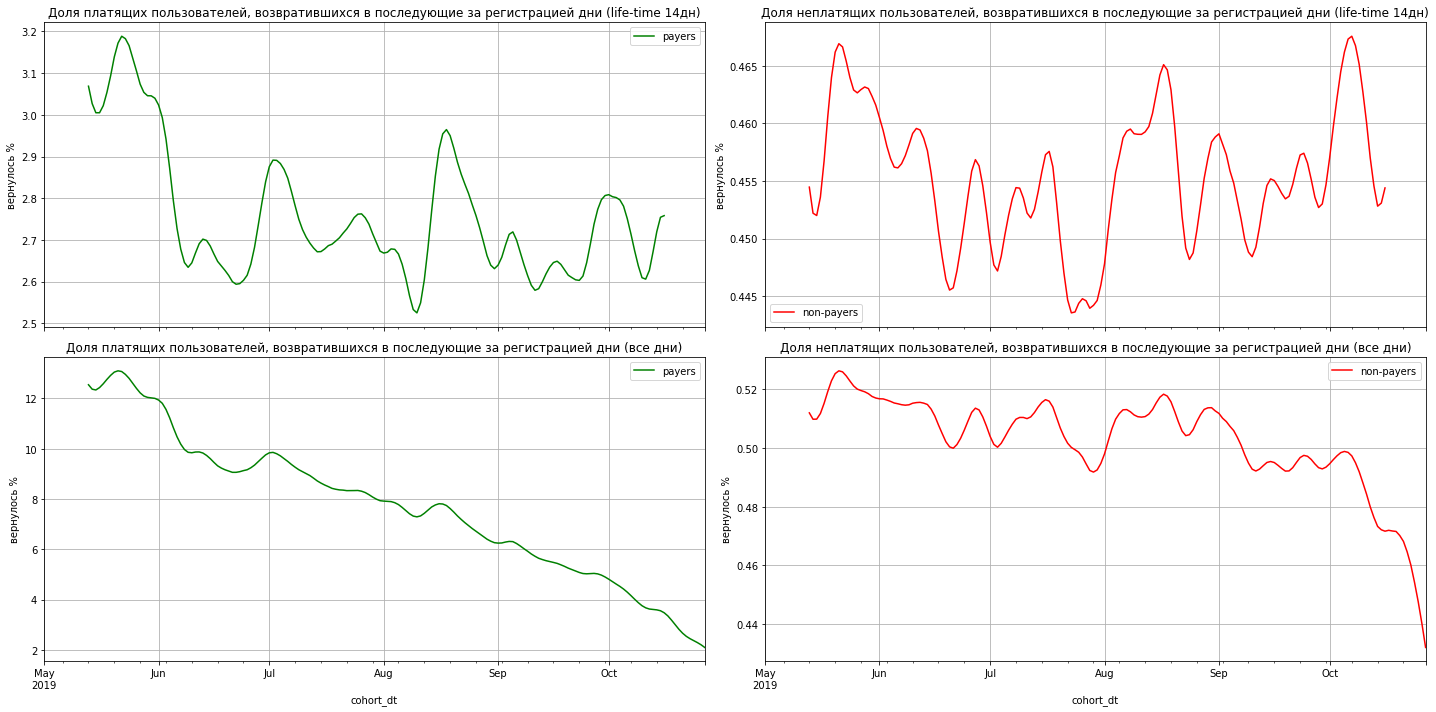

In [81]:
plt.figure(figsize=(20, 10))

ax1 = plt.subplot(2,2,1)

plt.title('Доля платящих пользователей, возвратившихся в последующие за регистрацией дни (life-time 14дн)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

visits_per_cohorts_pvt = research_RR_df.query(# здесь можно делать срез исходных данных по любому параметру выше
    'is_payer & life_time <= @ max_life_time & cohort_dt <= @last_cohort_dt'
    ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
# чтобы получить удержание, нужно поделить на число уникальных визитов в первый день, aka число регистраций, aka размер когорты
RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().plot( 
    kind='line', grid=True, color='green', label='payers', ax=ax1 )
plt.legend()

ax2 = plt.subplot(2,2,2)

plt.title('Доля неплатящих пользователей, возвратившихся в последующие за регистрацией дни (life-time 14дн)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

visits_per_cohorts_pvt = research_RR_df.query(
    '(~is_payer) & life_time <= @ max_life_time & cohort_dt <= @last_cohort_dt' 
    ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().plot( 
    kind='line', grid=True, color='red', label='non-payers', ax=ax2 )
plt.legend()

ax3 = plt.subplot(2,2,3,sharex=ax1)

plt.title('Доля платящих пользователей, возвратившихся в последующие за регистрацией дни (все дни)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

visits_per_cohorts_pvt = research_RR_df.query(
    'is_payer' 
    ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().plot( 
    kind='line', grid=True, color='green', label='payers', ax=ax3 )
plt.legend()

ax4 = plt.subplot(2,2,4,sharex=ax2)

plt.title('Доля неплатящих пользователей, возвратившихся в последующие за регистрацией дни (все дни)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

visits_per_cohorts_pvt = research_RR_df.query(
    '~is_payer' 
    ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().plot( 
    kind='line', grid=True, color='red', label='non-payers', ax=ax4 )
plt.legend()

plt.tight_layout()
plt.show()

**Анализ графиков**:
* Графики в органиченным life-time показывают, что на фоне флуктуаций (масштаб вертикальной оси адаптивен, поэтому абсолютные колебания уровней верхних графиков на самом деле малы) двунедельное удержание пользователей постоянное по когортам, но разительно отличается между платящими и неплатящими пользователями: у неплатящих средний уровень возврата за две недели порядка 0.455, а у платящих он около 2.7 кроме первого месяца, когда он порядка 3.1.  Последнее возможно, объясняется аномалией органических абонентов в первый месяц.
* Графики с неограниченным life-time, благодаря тому, что когорты подневные, а ретеншн нормируется на размер когорты, - они показывают в обратном времени поведение пользователей - платящих и неплатящих (усредненно по всем остальным параметрам):
 * Пользователь, который зарегистрировался с целью размещения заказа (сразу или позже), в среднем будет посещать приложение примерно раз в 180/14 = 13 дней - мы видим в первых когортах средний возврат на сайт на уровне 14 за 180 дней. Кстати, возможно, KPI для возврата инвестиций взят отсюда - расходы должны окупаться уже за 2 визита с целью покупки!
 * Из пользователей которые зарегистрировались, но не конвертировались в покупателей, только половина зайдет снова в течение порядка месяца и все - обратный график за месяц выходит на насыщение на уровне возвратов между 0.50-0.53. 
 * Поскольку доля платящих пользователей в среднем была определена порядка 6%, то 37% нагрузки на сайт составляют неплатящие пользователи, а 63% нагрузки генерируют покупатели.
 * Заметим, что хотя активность платящих пользователей не выказывает тренда к затуханию на протяжении всех 180 дней, но все же LTV выходит на насыщение.  Так что, хоть они и продолжают регулярно пользоваться услугой, но со временем находят способ делать это без дополнительных расходов!
* Как видим, **графики с неограниченным life-time более содержательно описывают поведение пользователей** - все из-за неудачного выбора слишком короткого бизнес KPI в 2 недели, что мы уже отмечали при анализе LTV как не соответствующего характеру использования приложения.

#### Анализ коэффициентов удержания в разбивке по странам

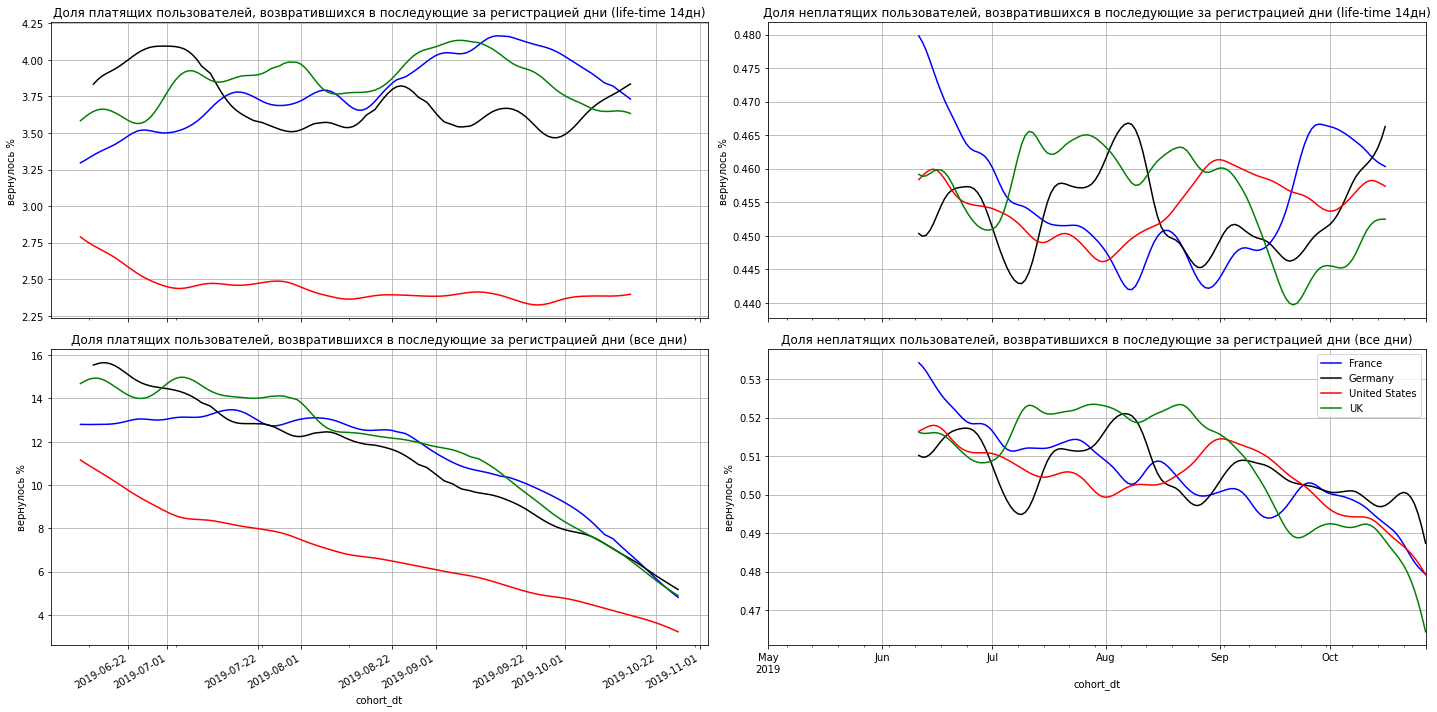

In [82]:
plt.figure(figsize=(20, 10))

ax1 = plt.subplot(2,2,1)
plt.title('Доля платящих пользователей, возвратившихся в последующие за регистрацией дни (life-time 14дн)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

ax2 = plt.subplot(2,2,2)
plt.title('Доля неплатящих пользователей, возвратившихся в последующие за регистрацией дни (life-time 14дн)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

ax3 = plt.subplot(2,2,3,sharex=ax1)
plt.title('Доля платящих пользователей, возвратившихся в последующие за регистрацией дни (все дни)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

ax4 = plt.subplot(2,2,4,sharex=ax2)
plt.title('Доля неплатящих пользователей, возвратившихся в последующие за регистрацией дни (все дни)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

for cn in list(set(list(users_df['country']))):
    
    visits_per_cohorts_pvt = research_RR_df.query(
        'is_payer & life_time <= @ max_life_time & cohort_dt <= @last_cohort_dt & country == @cn'
        ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
    RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
    RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().rolling(30).mean().plot( 
        kind='line', grid=True, color=cn_color_dict[cn], label=cn, ax=ax1 )

    visits_per_cohorts_pvt = research_RR_df.query(
        '(~is_payer) & life_time <= @ max_life_time & cohort_dt <= @last_cohort_dt & country == @cn' 
        ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
    RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
    RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().rolling(30).mean().plot( 
        kind='line', grid=True, color=cn_color_dict[cn], label=cn, ax=ax2 )

    visits_per_cohorts_pvt = research_RR_df.query(
        'is_payer & country == @cn' 
        ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
    RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
    RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().rolling(30).mean().plot( 
        kind='line', grid=True, color=cn_color_dict[cn], label=cn, ax=ax3 )

    visits_per_cohorts_pvt = research_RR_df.query(
        '(~is_payer) & country == @cn' 
        ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
    RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
    RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().rolling(30).mean().plot( 
        kind='line', grid=True, color=cn_color_dict[cn], label=cn, ax=ax4 )


plt.legend()
plt.tight_layout()
plt.show()

**Анализ графиков**:
* Оба типа графиков (как с органиченным life-time, так и с неограниченным) показывают одну и ту же закономерность:
 * Неплатящие пользователи не отличаются между странами - повторяют интегральную по странам модель поведения, США при этом менее стохастичны, чем Европа, так как там в 10 раз больше пользователей чем в каждой из европейских стран - имеем корень из 10 в дисперсии.
 * Платящие пользователи в Европе более консервативны в своей лояльности приложению - уровень двунедельного возврата пользователя в Европе (3.75) в 1.6 раза больше чем в США (2.35).  
* А вот из новых наблюдений по графику платящих пользователей с неограниченным life-time видно, что европейсткие пользователи все же успевают выйти на насыщение за один квартал - как раз на уровне 14 возвратов, тогда как пользователи из США так и продолжают регулярно пользоваться сервисом - линейный рост до 14 за два квартала.  На интегральном графике мы не видели совсем это насышение, так как в США в 10 раз больше пользователей, чем в любой из европейских стран.

#### Анализ коэффициентов удержания в разбивке по каналам

С исходном датасете присутствуют два поля channel:
* **reg_channel** - это канал, по которому пользователь был привлечен, метрика RR по нему наиболее легко трактуема, но при этом не учитывается то, что возврат пользователей идет и через другие каналы тоже (сами возвраты будут учитываться, но они будут приписаны каналу привлечения);
* **session_channel** - это канал, через который происходит реальный возврат - он не обязательно совпадет с каналом привлечения, семантику метрики по нему труднее представить, но ясно, что она лучше отразит реальные каналы возврата.

Поскольку разница в коде для обоих только в замене в одном месте (в условии query для фильтрации датасета) reg_chennel на session_channel, то посмотрим оба - может второй способ даст дополнительные выводы (как это было с ограничением life_time) 

**Вариант А: коэффициенты удержания в разбивке по каналам привлечения**

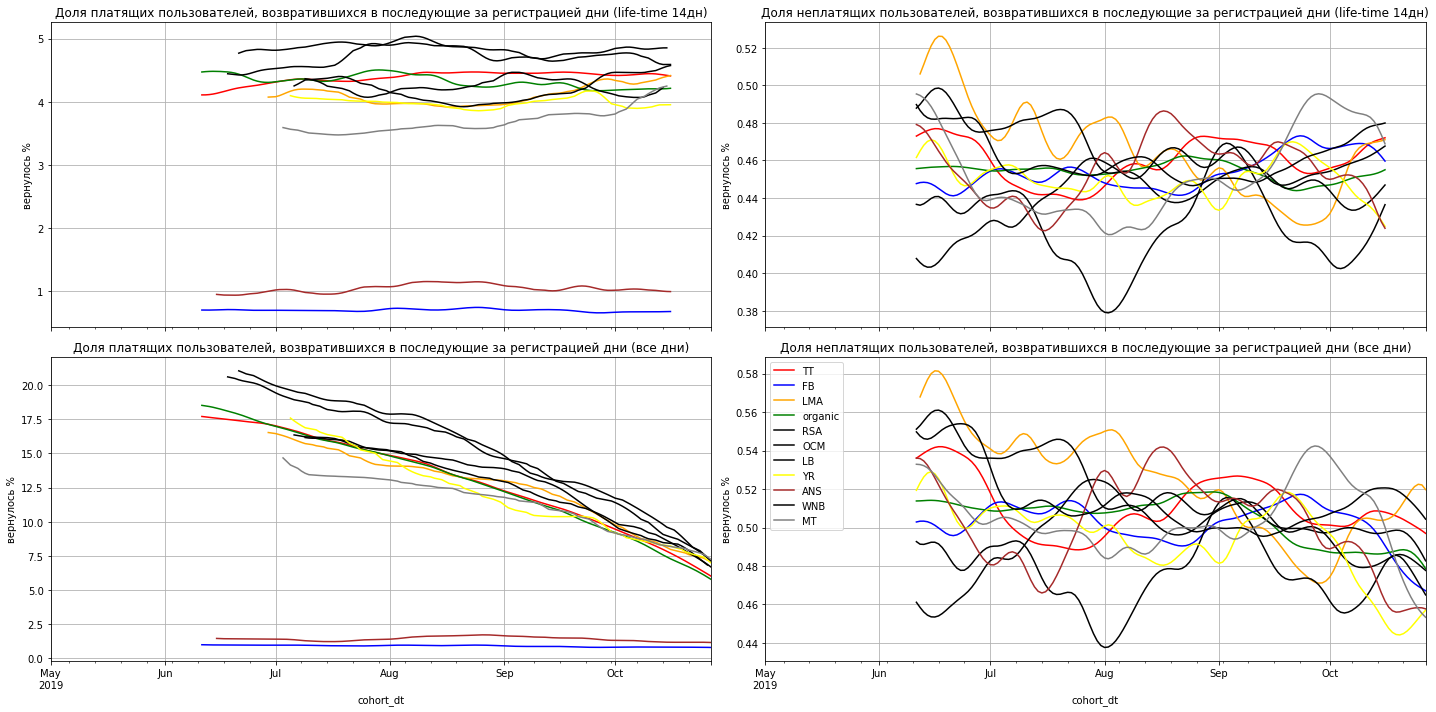

In [83]:
plt.figure(figsize=(20, 10))

ax1 = plt.subplot(2,2,1)
plt.title('Доля платящих пользователей, возвратившихся в последующие за регистрацией дни (life-time 14дн)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

ax2 = plt.subplot(2,2,2)
plt.title('Доля неплатящих пользователей, возвратившихся в последующие за регистрацией дни (life-time 14дн)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

ax3 = plt.subplot(2,2,3,sharex=ax1)
plt.title('Доля платящих пользователей, возвратившихся в последующие за регистрацией дни (все дни)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

ax4 = plt.subplot(2,2,4,sharex=ax2)
plt.title('Доля неплатящих пользователей, возвратившихся в последующие за регистрацией дни (все дни)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

for ch in list(set(list(users_df['reg_channel']))):
    
    visits_per_cohorts_pvt = research_RR_df.query(
        'is_payer & life_time <= @ max_life_time & cohort_dt <= @last_cohort_dt & reg_channel == @ch'
        ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
    RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
    RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().rolling(30).mean().plot( 
        kind='line', grid=True, color=color_dict[ch], label=ch_abbr[ch], ax=ax1 )

    visits_per_cohorts_pvt = research_RR_df.query(
        '(~is_payer) & life_time <= @ max_life_time & cohort_dt <= @last_cohort_dt & reg_channel == @ch' 
        ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
    RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
    RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().rolling(30).mean().plot( 
        kind='line', grid=True, color=color_dict[ch], label=ch_abbr[ch], ax=ax2 )

    visits_per_cohorts_pvt = research_RR_df.query(
        'is_payer & reg_channel == @ch' 
        ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
    RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
    RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().rolling(30).mean().plot( 
        kind='line', grid=True, color=color_dict[ch], label=ch_abbr[ch], ax=ax3 )

    visits_per_cohorts_pvt = research_RR_df.query(
        '(~is_payer) & reg_channel == @ch' 
        ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
    RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
    RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().rolling(30).mean().plot( 
        kind='line', grid=True, color=color_dict[ch], label=ch_abbr[ch], ax=ax4 )


plt.legend()
plt.tight_layout()
plt.show()

**Анализ графиков**:
* Как уже предполагалось ранее при анализе LTV по каналам, у двух каналов есть проблемы с возвратом привлеченных пользователей-покупателей - это:
 * **FaceBoom** - возврат за 2 недели покупателей вообще на уровне возврата непокупателей!  Так как канал составляет порядка 2/7 от всего маркетингового бюджета во втором квартале целевого периода, то его влияние на окупаемость рекламы огромно 
 * **AdNonSence** - канал малобюджетный, единственный, на котором возврат на порядок меньше, чем возврат на других малобюджетных каналах.  Влияние на общую окупаемость незначительное на фоне FaceBoom, но как кандидат в битве за доли процента после разрешения проблем FaceBoom годится.
* Пользователи-непокупатели ведут себя примерно одинаково (см. масштаб оси Y для непокупателей!) - как и интегрально по каналам.

**Вариант Б: коэффициенты удержания в разбивке по каналам возвращений**

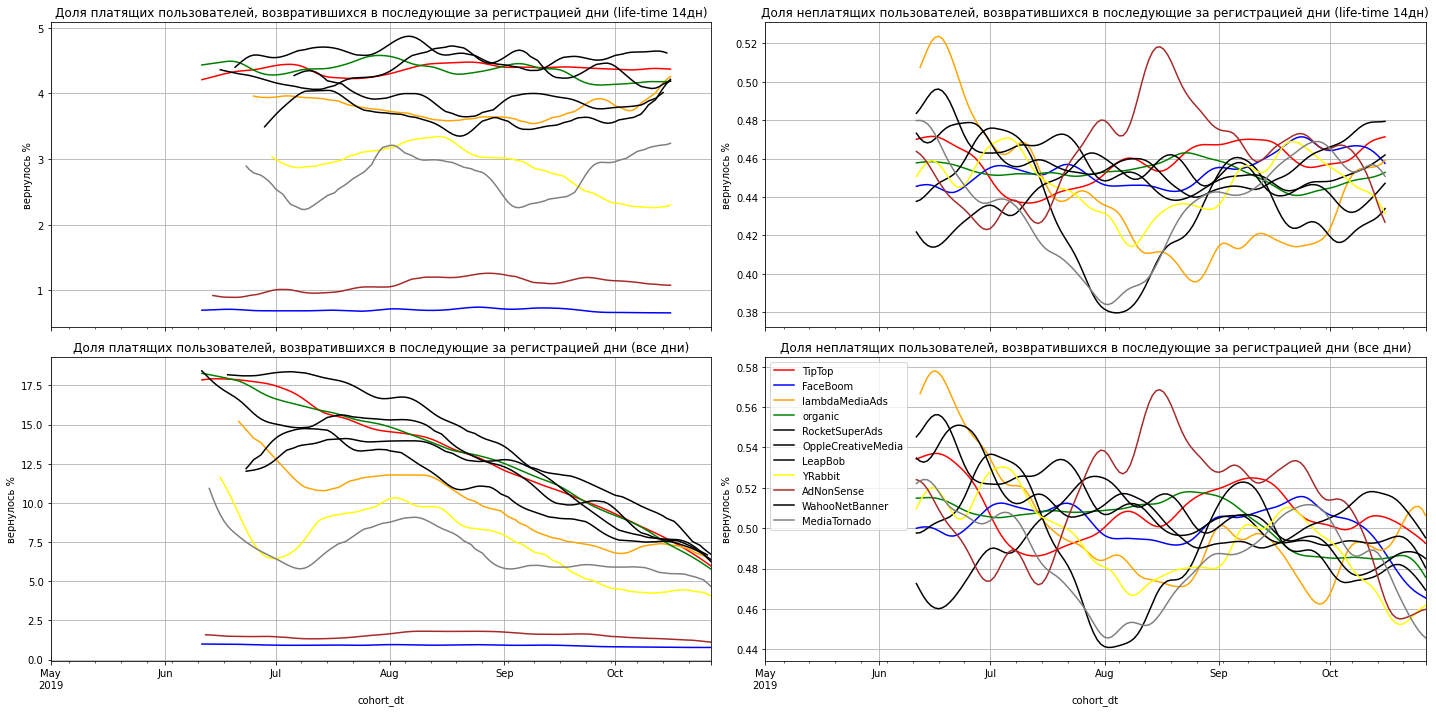

In [84]:
plt.figure(figsize=(20, 10))

ax1 = plt.subplot(2,2,1)
plt.title('Доля платящих пользователей, возвратившихся в последующие за регистрацией дни (life-time 14дн)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

ax2 = plt.subplot(2,2,2)
plt.title('Доля неплатящих пользователей, возвратившихся в последующие за регистрацией дни (life-time 14дн)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

ax3 = plt.subplot(2,2,3,sharex=ax1)
plt.title('Доля платящих пользователей, возвратившихся в последующие за регистрацией дни (все дни)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

ax4 = plt.subplot(2,2,4,sharex=ax2)
plt.title('Доля неплатящих пользователей, возвратившихся в последующие за регистрацией дни (все дни)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

for ch in list(set(list(users_df['reg_channel']))):
    
    visits_per_cohorts_pvt = research_RR_df.query(
        'is_payer & life_time <= @ max_life_time & cohort_dt <= @last_cohort_dt & session_channel == @ch'
        ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
    RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
    RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().rolling(30).mean().plot( 
        kind='line', grid=True, color=color_dict[ch], label=ch, ax=ax1 )

    visits_per_cohorts_pvt = research_RR_df.query(
        '(~is_payer) & life_time <= @ max_life_time & cohort_dt <= @last_cohort_dt & session_channel == @ch' 
        ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
    RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
    RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().rolling(30).mean().plot( 
        kind='line', grid=True, color=color_dict[ch], label=ch, ax=ax2 )

    visits_per_cohorts_pvt = research_RR_df.query(
        'is_payer & session_channel == @ch' 
        ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
    RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
    RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().rolling(30).mean().plot( 
        kind='line', grid=True, color=color_dict[ch], label=ch, ax=ax3 )

    visits_per_cohorts_pvt = research_RR_df.query(
        '(~is_payer) & session_channel == @ch' 
        ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
    RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
    RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().rolling(30).mean().plot( 
        kind='line', grid=True, color=color_dict[ch], label=ch, ax=ax4 )


plt.legend()
plt.tight_layout()
plt.show()

**Анализ графиков**:
* Мы видим возвращающие пользователей каналы, а не канал регистрации - поэтому непроблемные каналы на графике покупателей распределены гораздо шире, чем на гомологичных графиках варианта А - возвращается больше через тот канал, видимость рекламы которого выше для пользователей.  Поэтому вариант Б позволяет добавить следующие выводы:
 * один из каналов, отмеченный как лидер по низкому CAC ранее - **YRabbit**, маловиден в интернете, поэтому это оправдывает его низкие расценки;
 * совершенно непонятно, почему канал **TipTop** скромно ютится среди низкобюджетных - он съедает 4/7 маркетингового бюджета второго квартала целевого периода, то есть его видимость должна быть в 32 раза выше, чем у малобюджетных каналов!  Этого не видно по левым графикам варианта Б.

#### Промежуточные выводы:
* Каналы **FaceBoom** и **AdNonSense** по каким то причинам имеют низкое удержание покупателей - почти на уровне посетителей-непокупателей
* Канал **TipTop** вновь обращает на себя внимание **аномалией**: возврат "чужих" пользователей не соответствует бОльшей видимости канала (ожидаемой по бюджету и по кол-ву привлекаемых пользователей)

\*) *чужой для канала К пользователь - это пользователь, зарегистрировавшийся через другой канал Д, но возвращающийся в приложение через канал К* 

#### Анализ коэффициентов удержания в разбивке по устройствам

С исходном датасете присутствуют два поля device:
* **reg_device** - это устройство, с которого пользователь делал регистрацию;
* **session_device** - это устройство, с которого происходит реальный возврат.

В отличие от разбивки по каналам - в данном случае более трактуемым будет вариант Б, так как канал привязан вопросами оплаты к регистрации, а устройство привязано техническими проблемами к сессии

**Вариант А: коэффициенты удержания в разбивке по устройствам привлечения**

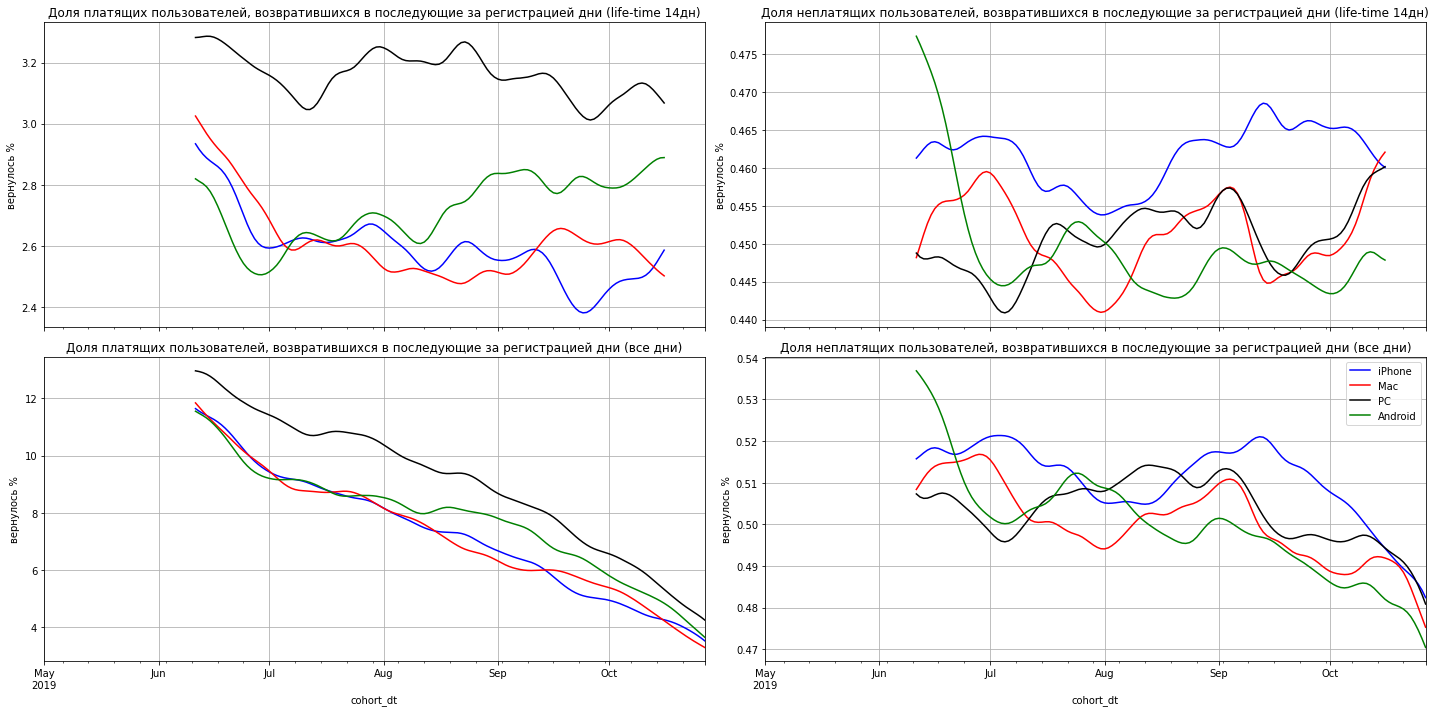

In [85]:
plt.figure(figsize=(20, 10))

ax1 = plt.subplot(2,2,1)
plt.title('Доля платящих пользователей, возвратившихся в последующие за регистрацией дни (life-time 14дн)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

ax2 = plt.subplot(2,2,2)
plt.title('Доля неплатящих пользователей, возвратившихся в последующие за регистрацией дни (life-time 14дн)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

ax3 = plt.subplot(2,2,3,sharex=ax1)
plt.title('Доля платящих пользователей, возвратившихся в последующие за регистрацией дни (все дни)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

ax4 = plt.subplot(2,2,4,sharex=ax2)
plt.title('Доля неплатящих пользователей, возвратившихся в последующие за регистрацией дни (все дни)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

dev_color_dict = {
    'iPhone':'blue',
    'Android':'green',
    'Mac':'red',
    'PC':'black'
}

for dev in list(set(list(users_df['reg_device']))):
    
    visits_per_cohorts_pvt = research_RR_df.query(
        'is_payer & life_time <= @ max_life_time & cohort_dt <= @last_cohort_dt & reg_device == @dev'
        ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
    RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
    RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().rolling(30).mean().plot( 
        kind='line', grid=True, color=dev_color_dict[dev], label=dev, ax=ax1 )

    visits_per_cohorts_pvt = research_RR_df.query(
        '(~is_payer) & life_time <= @ max_life_time & cohort_dt <= @last_cohort_dt & reg_device == @dev' 
        ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
    RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
    RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().rolling(30).mean().plot( 
        kind='line', grid=True, color=dev_color_dict[dev], label=dev, ax=ax2 )

    visits_per_cohorts_pvt = research_RR_df.query(
        'is_payer & reg_device == @dev' 
        ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
    RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
    RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().rolling(30).mean().plot( 
        kind='line', grid=True, color=dev_color_dict[dev], label=dev, ax=ax3 )

    visits_per_cohorts_pvt = research_RR_df.query(
        '(~is_payer) & reg_device == @dev' 
        ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
    RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
    RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().rolling(30).mean().plot( 
        kind='line', grid=True, color=dev_color_dict[dev], label=dev, ax=ax4 )


plt.legend()
plt.tight_layout()
plt.show()

**Анализ графиков**:
* Аномалий нет - не видно очевидных проблем ни у одного типа устройств.  Однако этот вывод лелать рано - так как это вариант А, более актуальным для проблем с устройствами ожидается вариант Б.
* По двунедельному критерию для бизнес KPI более выгодными являются покупатели, зарегистрировавшиеся по каналам PC и Android, однако покупатели Apple обычно платят дороже, поэтому, хоть из активность ниже, но в денежном выражении они могут не уступать мультивендорным устройствам

**Вариант Б: коэффициенты удержания в разбивке по устройствам возвращений**

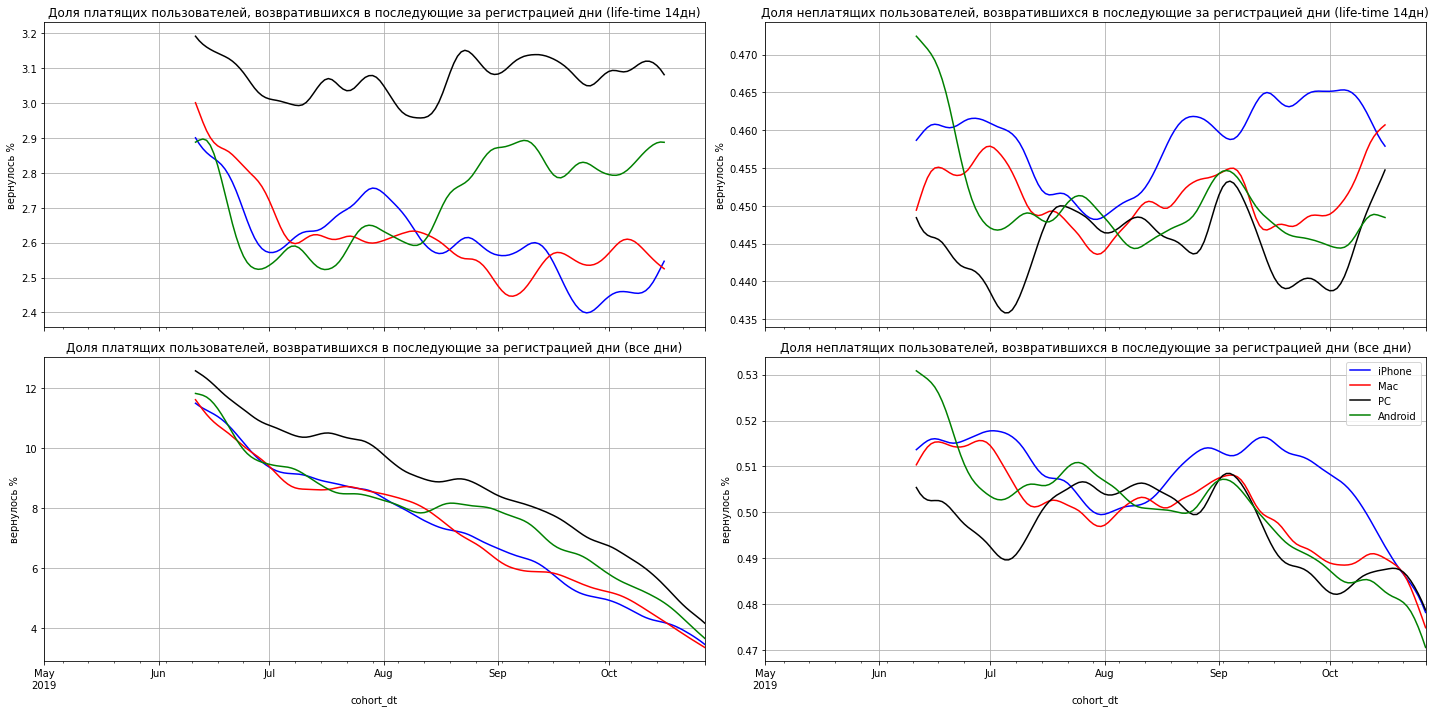

In [86]:
plt.figure(figsize=(20, 10))

ax1 = plt.subplot(2,2,1)
plt.title('Доля платящих пользователей, возвратившихся в последующие за регистрацией дни (life-time 14дн)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

ax2 = plt.subplot(2,2,2)
plt.title('Доля неплатящих пользователей, возвратившихся в последующие за регистрацией дни (life-time 14дн)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

ax3 = plt.subplot(2,2,3,sharex=ax1)
plt.title('Доля платящих пользователей, возвратившихся в последующие за регистрацией дни (все дни)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

ax4 = plt.subplot(2,2,4,sharex=ax2)
plt.title('Доля неплатящих пользователей, возвратившихся в последующие за регистрацией дни (все дни)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

dev_color_dict = {
    'iPhone':'blue',
    'Android':'green',
    'Mac':'red',
    'PC':'black'
}

for dev in list(set(list(users_df['reg_device']))):
    
    visits_per_cohorts_pvt = research_RR_df.query(
        'is_payer & life_time <= @max_life_time & cohort_dt <= @last_cohort_dt & session_device == @dev'
        ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
    RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
    RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().rolling(30).mean().plot( 
        kind='line', grid=True, color=dev_color_dict[dev], label=dev, ax=ax1 )

    visits_per_cohorts_pvt = research_RR_df.query(
        '(~is_payer) & life_time <= @max_life_time & cohort_dt <= @last_cohort_dt & session_device == @dev' 
        ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
    RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
    RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().rolling(30).mean().plot( 
        kind='line', grid=True, color=dev_color_dict[dev], label=dev, ax=ax2 )

    visits_per_cohorts_pvt = research_RR_df.query(
        'is_payer & session_device == @dev' 
        ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
    RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
    RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().rolling(30).mean().plot( 
        kind='line', grid=True, color=dev_color_dict[dev], label=dev, ax=ax3 )

    visits_per_cohorts_pvt = research_RR_df.query(
        '(~is_payer) & session_device == @dev' 
        ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
    RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
    RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().rolling(30).mean().plot( 
        kind='line', grid=True, color=dev_color_dict[dev], label=dev, ax=ax4 )


plt.legend()
plt.tight_layout()
plt.show()

**Анализ графиков**:
* Вариант Б не добавляет ничего в выводам варианта А - и при повторных возвратов не видно аномалий, свидетельствующих о проблемах приложения с каким-то устройством.

#### Промежуточные выводы:
* По двунедельному критерию для бизнес KPI более выгодными являются покупатели, зарегистрировавшиеся по каналам PC и Android, однако покупатели Apple обычно платят дороже, поэтому, хоть из активность ниже, но в денежном выражении они могут не уступать мультивендорным устройствам
* Проблем с удержанием пользователей какого-то определенного устройства нет

### Конверсия зарегистрировавшихся пользователей в покупатели - метрика Convertion Rate (CR)
Исследуем детально ситуацию с конверсией зарегистрированных пользователей в покупатели.

Метрика удержания RR похожа на метрику LTV, только учитываются не заказы, а сессии, при этом аггрегируются не ревеню, а кол-ва сессий.  Логика та же - развертываем когорты по лайфтайму и визуализируем по параметрам (страна, канал, устройство).  Но в отличие от LTV у нас появляется два типа пользователей - платяие и не платящие, чье поведение радикально отличается, поэтому их придется визуализировать отдельно.

Нам больше подойдет датафрейм users_df

In [87]:
users_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150008 entries, 0 to 150007
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   user_id          150008 non-null  int64         
 1   registration_dt  150008 non-null  datetime64[ns]
 2   reg_channel      150008 non-null  object        
 3   reg_device       150008 non-null  object        
 4   country          150008 non-null  object        
 5   is_payer         150008 non-null  bool          
 6   cohort_dt        150008 non-null  datetime64[ns]
 7   is_usa           150008 non-null  bool          
dtypes: bool(2), datetime64[ns](2), int64(1), object(3)
memory usage: 7.2+ MB


#### Анализ интегральной конверсии 

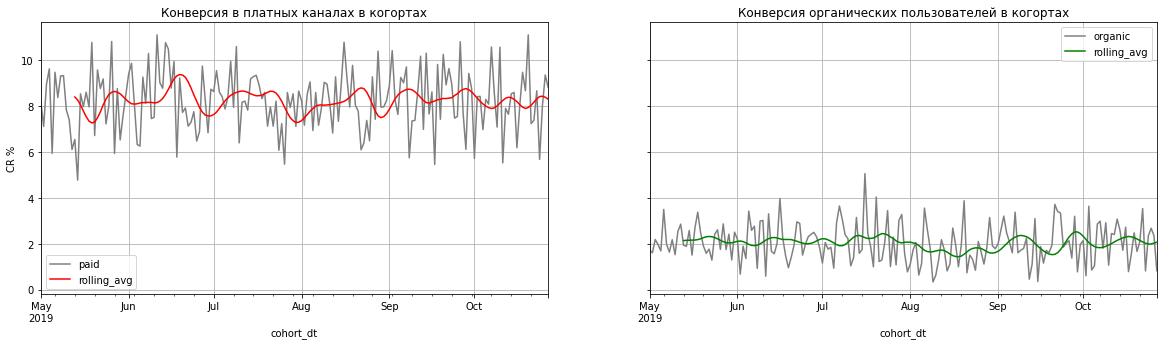

In [88]:
plt.figure(figsize=(20, 5))

ax1 = plt.subplot(1,2,1)
plt.title('Конверсия в платных каналах в когортах')
plt.ylabel('CR %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

CR_per_cohorts = users_df.query(
    'reg_channel != "organic"' # здесь даем все критерии фильтрации при разбивках далее
    ).groupby('cohort_dt').agg({'is_payer':'sum','user_id':'count'}).rename(
    columns={'is_payer':'nof_payers','user_id':'nof_users'})
CR_per_cohorts['CR_%'] = round(CR_per_cohorts['nof_payers'] / CR_per_cohorts['nof_users'] *100, 2)
CR_per_cohorts['CR_%'].plot( kind='line', grid=True, color='gray', label='paid', ax=ax1 )
CR_per_cohorts['CR_%'].rolling(3).mean(
).rolling(5).mean().rolling(7).mean().plot( kind='line', grid=True, color='red', label='rolling_avg', ax=ax1 )
plt.legend()

ax2 = plt.subplot(1,2,2,sharey=ax1)
plt.title('Конверсия органических пользователей в когортах')
plt.ylabel('CR %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

CR_per_cohorts = users_df.query(
    'reg_channel == "organic"'
    ).groupby('cohort_dt').agg({'is_payer':'sum','user_id':'count'}).rename(
    columns={'is_payer':'nof_payers','user_id':'nof_users'})
CR_per_cohorts['CR_%'] = round(CR_per_cohorts['nof_payers'] / CR_per_cohorts['nof_users'] *100, 2)
CR_per_cohorts['CR_%'].plot( kind='line', grid=True, color='gray', label='organic', ax=ax2 )
CR_per_cohorts['CR_%'].rolling(3).mean(
).rolling(5).mean().rolling(7).mean().plot( kind='line', grid=True, color='green', label='rolling_avg', ax=ax2 )
plt.legend()

#plt.tight_layout()
plt.show()

**Анализ графиков**:
* Ничего неожиданного - конверсия пользователей, привлеченных по платным каналам, выше, чем конверсия органических пользователей.  Мы нашли конкретные числа:
 * в платных каналах конверсия порядка 8%
 * для органических пользователей конверсия 2%

#### Анализ конверсии пользователей в разбивке по странам

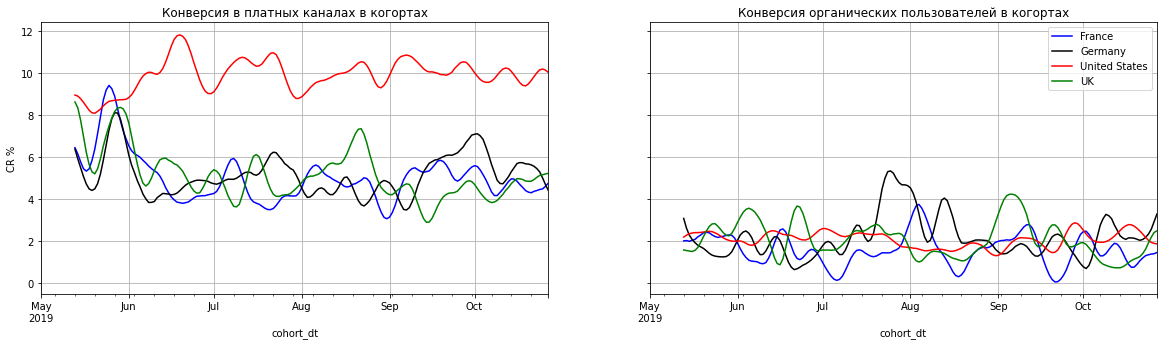

In [89]:
plt.figure(figsize=(20, 5))

ax1 = plt.subplot(1,2,1)
plt.title('Конверсия в платных каналах в когортах')
plt.ylabel('CR %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

ax2 = plt.subplot(1,2,2,sharey=ax1)
plt.title('Конверсия органических пользователей в когортах')
plt.ylabel('CR %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

for cn in list(set(list(users_df['country']))):

    CR_per_cohorts = users_df.query(
        'reg_channel != "organic" & country == @cn' 
        ).groupby('cohort_dt').agg({'is_payer':'sum','user_id':'count'}).rename(
        columns={'is_payer':'nof_payers','user_id':'nof_users'})
    CR_per_cohorts['CR_%'] = round(CR_per_cohorts['nof_payers'] / CR_per_cohorts['nof_users'] *100, 2)
    CR_per_cohorts['CR_%'].rolling(3).mean(
        ).rolling(5).mean().rolling(7).mean().plot(
        kind='line', grid=True, color=cn_color_dict[cn], label=cn, ax=ax1 )

    CR_per_cohorts = users_df.query(
        'reg_channel == "organic" & country == @cn'
        ).groupby('cohort_dt').agg({'is_payer':'sum','user_id':'count'}).rename(
        columns={'is_payer':'nof_payers','user_id':'nof_users'})
    CR_per_cohorts['CR_%'] = round(CR_per_cohorts['nof_payers'] / CR_per_cohorts['nof_users'] *100, 2)
    CR_per_cohorts['CR_%'].rolling(3).mean(
        ).rolling(5).mean().rolling(7).mean().plot(
        kind='line', grid=True, color=cn_color_dict[cn], label=cn, ax=ax2 )

plt.legend()
#plt.tight_layout()
plt.show()

**Анализ графиков**:
* Поведение органических пользователей опять одинаково по странам
* Конверсия пользователей из США в 2 раза выше в среднем, чем конверсия европейского пользователя (мы помним, что в удержании была обратная ситуация - там европейский пользователь возвращался в приложение в 1.6 раз чаще.  Совместно эти два фактора действуют в контрапункте и общий эффект разницы мал: европейский пользователь хуже конвертируется, но чаще пользуется, американский - наоборот.

#### Анализ конверсии пользователей в разбивке по устройствам

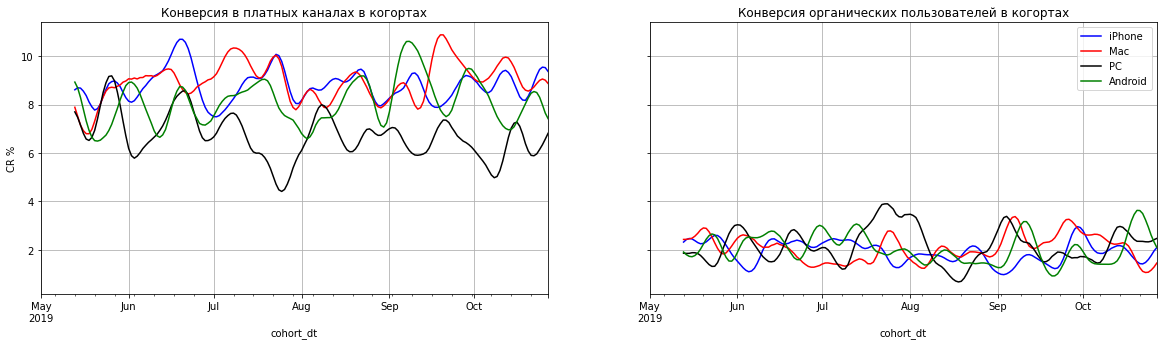

In [90]:
plt.figure(figsize=(20, 5))

ax1 = plt.subplot(1,2,1)
plt.title('Конверсия в платных каналах в когортах')
plt.ylabel('CR %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

ax2 = plt.subplot(1,2,2,sharey=ax1)
plt.title('Конверсия органических пользователей в когортах')
plt.ylabel('CR %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

for dev in list(set(list(users_df['reg_device']))):

    CR_per_cohorts = users_df.query(
        'reg_channel != "organic" & reg_device == @dev' 
        ).groupby('cohort_dt').agg({'is_payer':'sum','user_id':'count'}).rename(
        columns={'is_payer':'nof_payers','user_id':'nof_users'})
    CR_per_cohorts['CR_%'] = round(CR_per_cohorts['nof_payers'] / CR_per_cohorts['nof_users'] *100, 2)
    CR_per_cohorts['CR_%'].rolling(3).mean(
        ).rolling(5).mean().rolling(7).mean().plot(
        kind='line', grid=True, color=dev_color_dict[dev], label=dev, ax=ax1 )

    CR_per_cohorts = users_df.query(
        'reg_channel == "organic" & reg_device == @dev'
        ).groupby('cohort_dt').agg({'is_payer':'sum','user_id':'count'}).rename(
        columns={'is_payer':'nof_payers','user_id':'nof_users'})
    CR_per_cohorts['CR_%'] = round(CR_per_cohorts['nof_payers'] / CR_per_cohorts['nof_users'] *100, 2)
    CR_per_cohorts['CR_%'].rolling(3).mean(
        ).rolling(5).mean().rolling(7).mean().plot(
        kind='line', grid=True, color=dev_color_dict[dev], label=dev, ax=ax2 )

plt.legend()
#plt.tight_layout()
plt.show()

**Анализ графиков**:
* Поведение органических пользователей опять одинаково по устройствам
* Конверсия пользователей PC хуже всего- но это опять в противофазе в удержанием: совместные эффекты друг друга уменьшают
* Конверсия пользователей Apple немного лучше, чем у мультивендорных устройств - но это опять в противофазе в удержанием: совместные эффекты друг друга уменьшают

#### Анализ конверсии пользователей в разбивке по каналам
(теперь бедет одна колонка, так как organic - один из каналов)

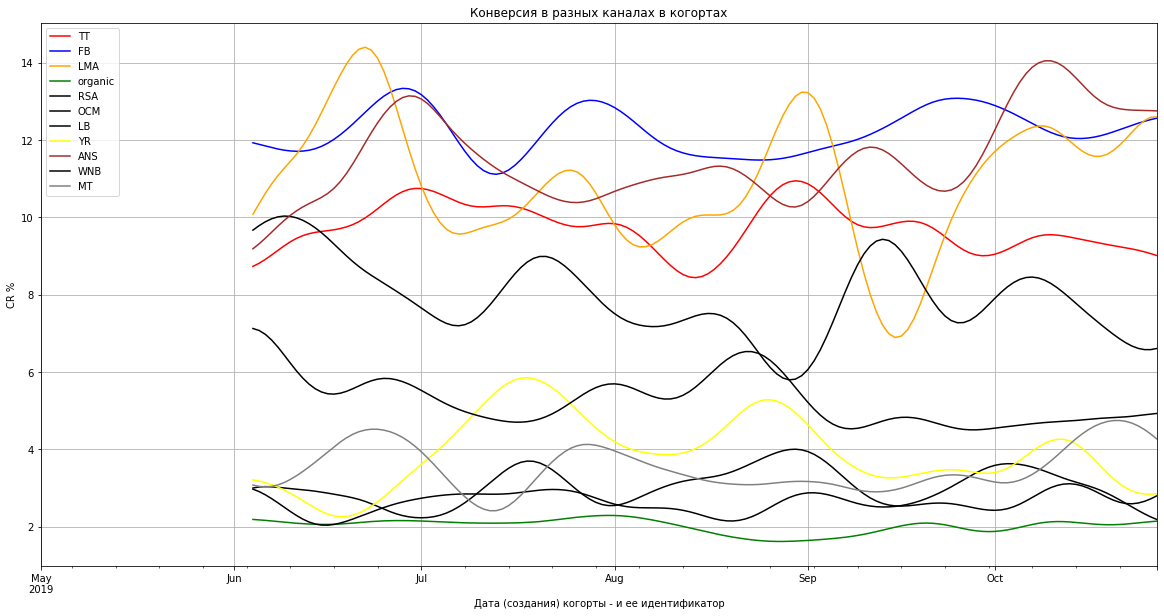

In [91]:




for ch in list(set(list(users_df['reg_channel']))):

    CR_per_cohorts = users_df.query(
        'reg_channel == @ch' 
        ).groupby('cohort_dt').agg({'is_payer':'sum','user_id':'count'}).rename(
        columns={'is_payer':'nof_payers','user_id':'nof_users'})
    CR_per_cohorts['CR_%'] = round(CR_per_cohorts['nof_payers'] / CR_per_cohorts['nof_users'] *100, 2)
    CR_per_cohorts['CR_%'].rolling(3).mean(
        ).rolling(5).mean().rolling(7).mean().rolling(11).mean().rolling(13).mean().plot(
        kind='line', grid=True, color=color_dict[ch], label=ch_abbr[ch], figsize=(20,10) )


plt.title('Конверсия в разных каналах в когортах')
plt.ylabel('CR %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')
plt.legend()
#plt.tight_layout()
plt.show()

**Анализ графиков**:
* лучшую конверсию показывают каналы, которые мы уже отмечали при канальном анализе раньше:
 * **FaceBoom** (2/7 бюджета маркетинга, худший по LTV, ROI и RR) - видимо, CR хороший, так как в какой-то комбинации других параметров успех разрешается только при покупке;
 * **TipTop** (4/7 бюджета маркетинга, каждый месяц завышает нам CAC, поэтому низкий ROI при хорошем LTV) - как видим, и конверсия хорошая: все показатели хорошие - плохо то, что регулярно поднимают тариф за свой маркетинг;
 * **AdNonSense** (малобюджетный, худший по LTV, ROI и RR) - видимо, причина проблем как и у FaceBoom;
 * **lambdeMediaAds** (лучший канал из малобюджетных по совокупности метрик) - включая, как видим, и конверсию.
* самый дешевый (после organic) канал **YRabbit** (лучший канал из малобюджетных кроме как по LTV) - видно почему: CR тянет вниз LTV, если поработают над конверсией, то смогут обогнать lambdaMediaAds

## Дополнительное исследование проблем удержания у канала FaceBoom
Программы проекта попунктно выполнена, выводов достаточно, для отчета, однако одна важная аномалия осталась не проясненной - мы не понимаем причины аномально низкого удержания пользователей привлеченных по каналу FaceBoom - по другим независимым метрикам это хороший канал, второй по величине, и исправление его удержания могло бы сильно улучшить всю прибыльность приложения. 

### Исследование продолжительности сессий

Посмотрим, есть ли симптомы технических проблем - таковые обычно связаны с трудностью каких-то действий пользователя.  К сожалению мы не видим опыт пользователей до регистрации, но после регистрации у нас есть еще продолжительность сессий: 

In [92]:
sessions_df['duration_sec'] = ((sessions_df['session_end'] - sessions_df['session_start']) / timedelta(seconds=1)).astype('int')

In [93]:
sessions_df.pivot_table(index='channel', columns='device', values='duration_sec', aggfunc='median')

device              Android     Mac      PC  iPhone
channel                                            
AdNonSense           1238.0  1167.0  1248.0  1178.0
FaceBoom             1262.0  1247.0  1289.0  1234.0
LeapBob              1265.0  1236.0  1267.0  1267.5
MediaTornado         1250.0  1233.0  1294.5  1207.0
OppleCreativeMedia   1275.5  1239.0  1228.0  1135.0
RocketSuperAds       1264.0  1224.0  1232.0  1255.5
TipTop               1252.0  1223.0  1228.0  1265.5
WahooNetBanner       1210.0  1274.5  1232.0  1242.0
YRabbit              1203.0  1288.0  1200.5  1255.0
lambdaMediaAds       1285.5  1245.0  1232.0  1200.0
organic              1256.0  1242.0  1240.0  1238.0

Нет разницы, посмотрим **доли аномально коротких сессий**

In [94]:
limit = 30 # медианное время сессий 1200-1300 сек 
short_sessions_df = sessions_df.query('duration_sec <= @limit').pivot_table(
    index='channel', columns='device', values='duration_sec', aggfunc='count')

all_sessions_df = sessions_df.pivot_table(index='channel', columns='device', values='duration_sec', aggfunc='count')

print('Доля коротких сессий','(менее',limit,'секунд) в %')
(short_sessions_df / all_sessions_df * 10000).astype('int') / 100

Доля коротких сессий (менее 30 секунд) в %


device              Android   Mac    PC  iPhone
channel                                        
AdNonSense             2.20  1.69  1.99    1.88
FaceBoom               1.72  1.71  1.47    1.82
LeapBob                1.41  1.73  1.48    1.47
MediaTornado           2.10  1.79  1.88    1.39
OppleCreativeMedia     1.75  1.22  1.50    1.97
RocketSuperAds         1.97  1.59  1.73    1.54
TipTop                 1.65  1.78  1.76    1.60
WahooNetBanner         1.71  1.22  1.70    1.39
YRabbit                1.91  1.35  1.78    1.59
lambdaMediaAds         1.53  1.23  1.96    2.07
organic                1.57  1.80  1.78    1.73

In [95]:
limit = 120 # медианное время сессий 1200-1300 сек 
short_sessions_df = sessions_df.query('duration_sec <= @limit').pivot_table(
    index='channel', columns='device', values='duration_sec', aggfunc='count')

all_sessions_df = sessions_df.pivot_table(index='channel', columns='device', values='duration_sec', aggfunc='count')

print('Доля коротких сессий','(менее',limit,'секунд) в %')
(short_sessions_df / all_sessions_df * 10000).astype('int') / 100

Доля коротких сессий (менее 120 секунд) в %


device              Android   Mac    PC  iPhone
channel                                        
AdNonSense             6.32  6.07  6.95    6.50
FaceBoom               6.44  6.05  6.15    6.41
LeapBob                6.20  7.16  6.45    5.82
MediaTornado           6.48  6.23  6.87    6.03
OppleCreativeMedia     6.41  6.44  6.81    7.11
RocketSuperAds         6.89  6.36  5.61    6.65
TipTop                 6.12  6.94  5.82    6.23
WahooNetBanner         6.62  5.87  6.50    6.41
YRabbit                7.27  6.27  7.04    6.45
lambdaMediaAds         6.55  6.74  7.13    7.71
organic                6.41  6.60  6.63    6.63

#### Дополнительные выводы:
* Аномальных падений сессии в разбивке каналы Х устройства не обнаружено 

### Исследование потери информации о регистрации 
Предполагается, что после перехода абонента в приложение, его опыт уже не зависит от канала.
Что же еще может зависеть от канала - быть может при каких-то часто встречающихся условиях, зависящих от канала, теряется user_id.  Тогда по факту один и тот же физический пользователь через канал FaceBoom вынужден снова и снова регистрироваться, чтобы продолжать пользоваться приложением.  К сожалению, это по факту выразится как проблему удержания зарегистрированных пользователей - ее мы уже исследовали от устройства и ничего похоженго на аномалию не обнаружили.  Но при том исследовании мы смотрели все каналы - быть может, эффект был незаметен на фоне остальных?  Повторим исследование удержания, но теперь только для одного канала FaceBoom:

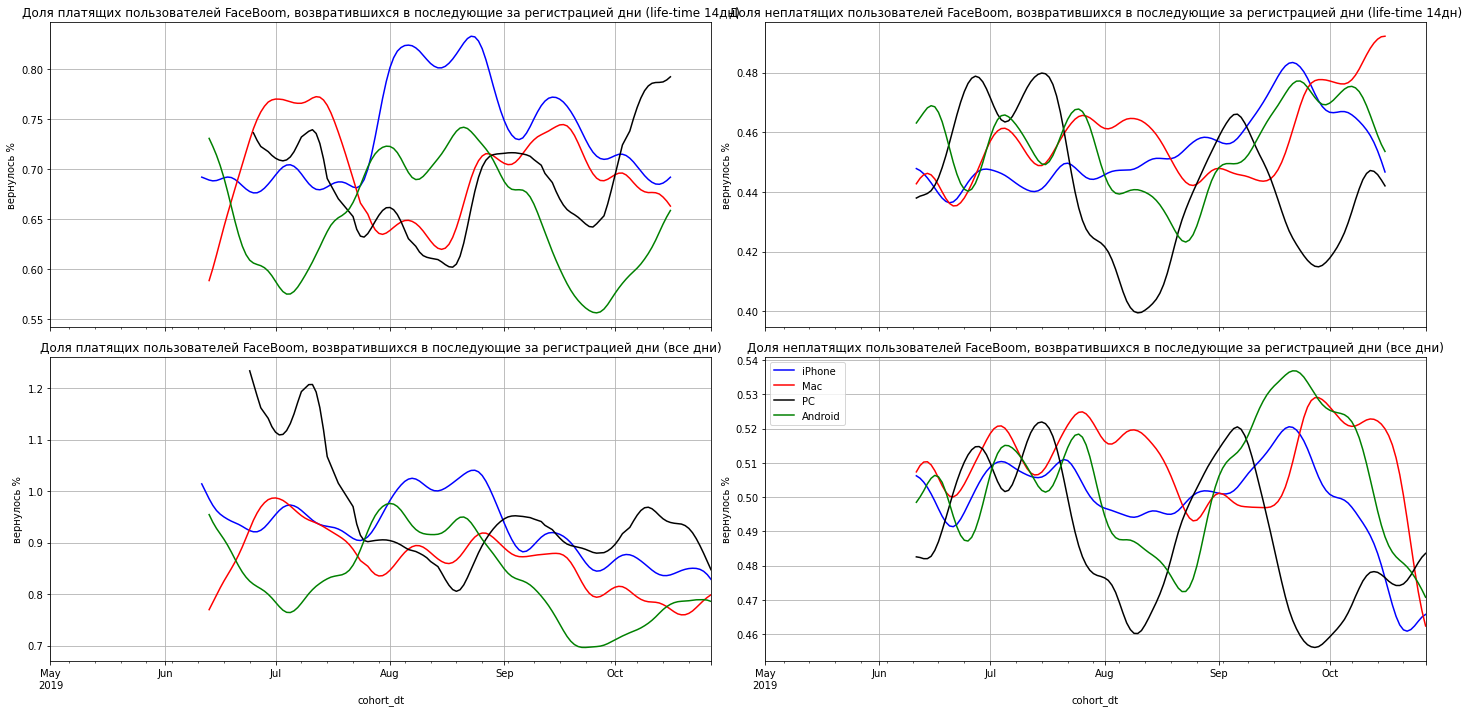

In [96]:
plt.figure(figsize=(20, 10))

ax1 = plt.subplot(2,2,1)
plt.title('Доля платящих пользователей FaceBoom, возвратившихся в последующие за регистрацией дни (life-time 14дн)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

ax2 = plt.subplot(2,2,2)
plt.title('Доля неплатящих пользователей FaceBoom, возвратившихся в последующие за регистрацией дни (life-time 14дн)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

ax3 = plt.subplot(2,2,3,sharex=ax1)
plt.title('Доля платящих пользователей FaceBoom, возвратившихся в последующие за регистрацией дни (все дни)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

ax4 = plt.subplot(2,2,4,sharex=ax2)
plt.title('Доля неплатящих пользователей FaceBoom, возвратившихся в последующие за регистрацией дни (все дни)')
plt.ylabel('вернулось %')
plt.xlabel('Дата (создания) когорты - и ее идентификатор')

dev_color_dict = {
    'iPhone':'blue',
    'Android':'green',
    'Mac':'red',
    'PC':'black'
}

for dev in list(set(list(users_df['reg_device']))):
    
    visits_per_cohorts_pvt = research_RR_df.query(
        'is_payer & life_time<= @max_life_time & cohort_dt<= @last_cohort_dt & session_device== @dev & reg_channel== "FaceBoom"'
        ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
    RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
    RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().rolling(30).mean().plot( 
        kind='line', grid=True, color=dev_color_dict[dev], label=dev, ax=ax1 )

    visits_per_cohorts_pvt = research_RR_df.query(
        '(~is_payer) & life_time<= @max_life_time & cohort_dt<= @last_cohort_dt & session_device== @dev & reg_channel== "FaceBoom"' 
        ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
    RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
    RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().rolling(30).mean().plot( 
        kind='line', grid=True, color=dev_color_dict[dev], label=dev, ax=ax2 )

    visits_per_cohorts_pvt = research_RR_df.query(
        'is_payer & session_device == @dev  & reg_channel == "FaceBoom"' 
        ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
    RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
    RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().rolling(30).mean().plot( 
        kind='line', grid=True, color=dev_color_dict[dev], label=dev, ax=ax3 )

    visits_per_cohorts_pvt = research_RR_df.query(
        '(~is_payer) & session_device == @dev  & reg_channel == "FaceBoom"' 
        ).pivot_table(columns='life_time', index='cohort_dt', values='user_id', aggfunc='nunique')
    RR_per_cohorts_pvt = visits_per_cohorts_pvt.div(visits_per_cohorts_pvt[0], axis=0).drop(columns=0)
    RR_per_cohorts_pvt.T.sum().rolling(3).mean().rolling(5).mean().rolling(7).mean().rolling(30).mean().plot( 
        kind='line', grid=True, color=dev_color_dict[dev], label=dev, ax=ax4 )


plt.legend()
plt.tight_layout()
plt.show()

#### Дополнительные выводы:
* разница с прошлым гомологичным исследованием только в том, что левый нижний график более не показывает монотонного роста по времени (обратно когортам) - что еще раз подтверждает, что удержание пользователей FaceBoom меньше двух недель, о чем мы уже выводили;
* к сожалению опять никакой зависимости от устройства при фокусе на однос канале не обнаружено

#### Гипотеза о проблемах FaceBoom
Отрицательный результат - тоже результат, теперь мы достоверно уверены, что проблем у устройств и/или стабильности сессий нет.  Но название канала (это ведь искаженный намеренно Facebook) наводит на идею такой гипотезы:
**Преамбула**:
1. часть каналов, наверняка, соцсети
2. при входе во многие приложения предлагается альтернативный вариант аутентификации - по id соцсети.  Многие пользователи используют для скорости.
**Гипотеза**:
аутентификация через FaceBoom по техническим причинам работает с ошибкой, что приводит к повторным созданиям пользователя приложения одним и тем же физическим пользователем.  Возможно, это читинг со стороны FaceBoom для искусственного завышения маркетинговых костов в свою сторону.

## Выводы и рекомендации по проекту

### Ответы на основные вопросы проекта

#### Окупается ли реклама в целом?
1. При применении бизнес-KPI окупаемости в 2 недели, окупается только реклама в целом по Европе.  Вся реклама не окупается из-за убыточности привлечения в США.  Данный пункт верен как с учетом органических пользователей, так и без них.
2. При учете всего жизненного дохода с одного абонента за весь анализируемый период реклама окупается - и в целом, и отдельно по США, и с учетом органических пользователей и без них.  Но периодом окупаемости будет 50 дней по США без органических, и 30 дней в целом без органических пользователей 
3. Независимо от того, какой регион рассматривать, выбор двунедельного критерия окупаемости не отражает прибыльности данного приложения, так как оставляет за бортом 2/3 дохода с европейских пользователей и 1/2 дохода с американских

#### Какие параметры (устройства, страны и каналы) снижают окупаемость рекламы?
1. Основным фактором снижающим окупаемость является канал TipTop в США – он съедает 4/7 маркетингового бюджета, поэтому его влияние определяюще!  Данный канал убыточен по метрике 2 недель, но не по всему анализируемому периоду – что определяет похожее поведение окупаемости в целом
2. Вторым по значимости фактором снижения окупаемости является канал FaceBoom в США – он одинаково убыточен и на 2 неделях и на всем анализируемом периоде.  К сожалению, он съедает еще 2/7 маркетингового бюджета
3. Таким образом, 6/7 расходов на привлечение расходуются в убыток по метрикам двух недель, и 2/7 из них убыточны даже по всему анализируемому периоду
4. В Европе единственным убыточным каналом является AdNonSense, но он малобюджетный, и не влияет на общую окупаемость – он одинаково убыточен и на 2 неделях и на всем анализируемом периоде.  Значение данного канала в нашем анализе в том, что из-за него мы не можем сделать вывод об окупаемости рекламы по каждой в отдельности Европейской стране – так как косты рекламы привязаны к странам не напрямую, а через территории работы каналов, а все европейские каналы работают во всех трех странах.
5. Остальные каналы окупаются 
6. Анализ окупаемости по устройствам не входил в программу данного проекта – по устройствам мы анализировали по устройствам только удержание и конверсию – на предмет возможных проблем.  Однако каких-либо аномалий на стороне устройств не было обнаружено даже для канала с проблемным удержанием FaceBoom. 

#### Чем могут быть вызваны проблемы окупаемости?
1. Исследование показало, что причиной убыточности TipTop является ежемесячное повышение им тарифов – каждый месяц CAC по данному каналу скачкообразно подрастает, съедая почти весь аккумулированный за этот месяц LTV. Предполагается наличие у TipTop инсайдерской информации о наших доходах, или условия по revenue share в тарифе.
2. Исследование показало, что причиной убыточности FaceBoom и AdNonSense является аномально низкое удержание – на уровне непокупателей.  Это удержание можно описать так: из пользователей этого канала, зарегистрировавшихся в приложении только половина возвращается второй раз, причем делает это в 1-2 недели.  Для сравнения пользователей других каналов можно описать так: зарегистрировавшийся пользователь возвращается в приложение каждые 2 недели, причем продолжает делать это как минимум весь анализируемый период (полгода). Предполагается наличие технической проблемы при регистрации пользователя по id соцсети, приводящей к тому, что один физический пользователь вынужден регистрироваться снова и снова, чтобы продолжать пользоваться приложением, создавая новые user_id в приложении.  Возможно, это сознательный читинг с целью раздувания фактической стоимости рекламы.
3. Также следует отметить как причину заниженной окупаемости неверный выбор бизнес KPI в две недели - исследование показало, что данный период оставляет неучтенным 2/3 дохода от европейских пользователей и 1/2 дохода от американских - это при фиксированных костах за маркетинг.  То есть прибыльность, учитываемая бизнес-планом, занижена более чем в два раза.
4. Также к проблемам учета окупаемости следует отнести обнаруженный при исследовании факт ошибочного учета в майских когортах платных пользователей как органических - при этом все косты за май на них присутствуют в данных.  Что занижает окупаемость рекламы.

### Общий вывод
Причиной убыточности привлечения пользователей приложения Procrastinate Pro+  являются недостатки в работе с маркетинговыми партнерами для основных каналов маркетинга (6/7 бюджета второго квартала анализируемого периода):
1. TipTop (США) - партнер все время пересматривает свои расценки в сторону увеличения, съедая всю нашу маржу с уже привлеченных пользователей
2. FaceBoom (США) - партнер не может или не хочет обеспечить надежное удержание зарегистрированных пользователей, раздувая повторные регистрации и как результат - наши косты

### Рекомендации отделу маркетинга
1. Прояснить с партнером TipTop причины ежемесячных повышений расценок - основания: график CAC канала по когортам.
2. Параллельно проконсультироваться с отделом безопасности про возможный конфликт интересов в сторону TipTop - партнер меняет расценки, как будто ему известна наша маржа - основания: сравнение канальных графиков LTV и CAC, а также ROI.
3. Прояснить с партнером TipTop причины катастрофически низкого удержания в канале - основания: график возвратов по каналам.
4. Параллельно проконсультироваться с отделом ИТ поддержки приложения про возможность технических ошибок в приложении при регистрации через соцсети (с использованием аутентификации соцсетей) - вопрос: возможно ли что один физический пользователь вынужден создавать новые uaer_id в прилжении при продолжении пользования прложением.
5. Обсудить с авторами бизнес-плана целесообразность изменения KPI окупаемости с 2 недель на 8 недель - основание: интегральные по всем когортам графики LTV и ROI.
6. Параллельно поставить вопрос перед Директором по мотивации персонала об искуственном занижении своих бонусных KPI - основание: обнаруженный аналитиком данных факт, что KPI по бизнес цели подразделения не учитывает больше половины достигаемого результата. :)

In [97]:
print('run all execution has been finished OK !')### Удержание пользователей

run all execution has been finished OK !
